In [1]:
# Validation of the steady-state simulation - Case 2: AeroCNN-I
##
## 1. Train/Validation/Test dataset ratio = 0.7/0.2/0.1
## 2. Using CNN structure to extract geometry features (characteristics)
## 3. The time interval used to train is revolution 10 to 11.
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from scipy import interpolate
from sklearn.model_selection import train_test_split

import datetime
%matplotlib inline

In [2]:
### Defining parameters and hyperparameters of the model

n_kernels=400 # Number of filters (kernels) in Convolutional layer
n_units=256 # Number of units in the hidden layer of the MLP network
n_layers=5
input_size = 110 # Size of input for the network (110 coefficients and 3 other parameters, time, h, beta)
lr = 1e-04 # Learning rate of the network
test_rate = 0.1 # Defines the ratio of test dataset
val_rate = 0.2 # Defines the ratio of validation dataset
batch_size = 200 # Mini-batch size
l2_regularizer=1e-07

In [3]:
# The number of revolution
t_lower = 10 # Lower limit of the interval of time
t_upper = 11 # Upper limit of the interval of time

In [4]:
# Changing working directory

main_directory = 'D:\\VAWT_data\\flap_steady\\flap_steady'
os.chdir(main_directory)

In [5]:
# Case number: NACA 0018 without Gurney flap - case 0
# the others, which are Case 1,2,4,5,7,8,13,14,15,16,17,18,19,20,21

In [6]:
## Basic parameters

c = 1 # Chord length
h = np.array([0.01, 0.02, 0.03]) * c # Height of the Gurney flaps
thickness = 0.02 * h # Thickness of the Gurney flaps
beta = np.linspace(30, 90, 5).reshape((5,1))

beta = beta[-1]

In [7]:
h = h.reshape((-1,1))
thickness = thickness.reshape((-1,1))

In [8]:
t_interval = 0.001
t_len = int((t_upper-t_lower) / t_interval)

n_beta = len(beta)# Number of the Gurney flap inclination
n_h = len(h) # Number of the height of the Gurney flaps

flap_interval = int(0.03/0.002)

In [9]:
## Creating Input dataset
# Defining time as input

main_directory = 'D:\\VAWT_data'
cm_dir = main_directory + "\\blade_1_cm_data"
cm_list = os.listdir(cm_dir)
os.chdir(cm_dir)

In [10]:
cm_target = [file for file in cm_list if file.endswith('.csv')]
cm_target = sorted(cm_target, key=lambda s: int(re.search(r'\d+',s).group()))
cm_target = cm_target[-10:-7]
n_data = len(cm_target) # Number of txt files from which the aerodynamic coefficients are extracted
n_cases = n_data * t_len # Total number of cases(Number of geometries * Number of angles of attack)

In [11]:
cm_target

['case13cm_blade1.csv', 'case14cm_blade1.csv', 'case15cm_blade1.csv']

In [12]:
### Create input and output data
### This function is the main framework where data are reordered with respect to the shape the NNs require.
### Each input features are made by calling the corresponding functions, which generate the data,
### e.g., time, cm, h, beta, coordinates of airfoil and Gurney flaps, etc.
def genereate_input_output(cm_target, n_beta, t_len, normalize:bool=False):
    
    input_time_cm = time_and_cm(cm_target)
    t = input_time_cm[:,0].reshape((-1, 1))
    cm = input_time_cm[:,1].reshape((-1, 1))
    
    #hh = generate_h(n_beta, t_len, normalize)
    #bb = generate_beta(n_beta, t_len, normalize)
    total_coords = generate_coordinates(n_cases)
    
    # Concatenate data for input dataset
    x_time = t
    x_coord = total_coords.reshape((n_cases,2,flap_interval,1))
    
    # Generating output dataset (depending on whether the data be normalized or not)
    if normalize==True:
        y = (cm-np.min(cm))/(np.max(cm)-np.min(cm))
    else:
        y = cm
    print("Dimension - x_time: ", x_time.shape)
    print("Dimension - x_coordinates: ", x_coord.shape)
    print("Dimension - y: ", y.shape)
    
    return x_time, x_coord, y, t, cm

In [13]:
## Creating time for input, and Cm (moment coefficient) for output
def time_and_cm(cm_target):
    cm_df = pd.DataFrame()
    for i, file in enumerate(cm_target):
        df = pd.DataFrame()
        
        data = pd.read_csv(file, header=None)
        df = pd.concat([df, data], axis=0)
        
        time = df.iloc[:,0].values
        cm = df.iloc[:,1].values
        
        time_beUsed = time[np.where(np.logical_and(time>=t_lower, time<t_upper))]
        cm_beUsed = cm[np.where(np.logical_and(time>=t_lower, time<t_upper))]
        
        # Handle the time that is duplicated because of digits
        # Also, outliers are regulated at the second conditional statement.
        time_beUsed = handler_time(time_beUsed)
        cm_beUsed = handler_cm(cm_beUsed)
        
        linear_func = interpolate.interp1d(time_beUsed, cm_beUsed,
                                           bounds_error=False,kind='quadratic',
                                           fill_value='extrapolate')
        time_interp = np.arange(10, 11, t_interval).reshape((-1,1))
        cm_interp=linear_func(time_interp).reshape((-1,1))
        
        cm_df = pd.concat([cm_df, pd.DataFrame(np.hstack((time_interp, cm_interp)))], axis=0)
    
    input_time_cm = cm_df.iloc[:,:].values
    print("Dimension - time and Cm: ", input_time_cm.shape)
    return input_time_cm

In [14]:
# Handling duplicated time value
def handler_time(time_beUsed):
    for i in range(len(time_beUsed)):
        if time_beUsed[i]==time_beUsed[i-1]:
            time_beUsed[i] += 0.0005
            
    return time_beUsed

In [15]:
# Handling outlier, (if there are)
def handler_cm(cm_beUsed):
    period = int(len(cm_beUsed) / 5)
    for i in range(len(cm_beUsed)):
        if np.abs(cm_beUsed[i]-cm_beUsed[i-1])>0.3:
            cm_beUsed[i-1] = cm_beUsed[i-1 + period]
            
    return cm_beUsed

In [16]:
## Defining beta, the Gurney flap inclination
## In case of mere NACA0018, the bb in those indexes are considered as zero.
def generate_beta(n_beta=n_beta, t_len=t_len, normalize=True):

#     beta_0 = np.zeros((t_len,1)) # Values for sheer NACA0018
    b_ = np.ones((t_len,1)) # Template for the inclination for a single h and single beta
    bb_imp = np.zeros((t_len*n_beta,1))

    for j in range(n_beta):
        b_imp = b_ * beta[j]
        bb_imp[t_len*j:t_len*(j+1),:] = b_imp[:,:]

    bb_imp = bb_imp.reshape((-1,1))
    bb = bb_imp
    if normalize==True:
        bb = bb / np.max(beta)
    
    print("Dimension - inclination(beta): ", bb.shape)

    return bb

In [17]:
## Defining the Gurney flap height
## In case of mere NACA0018, the hh in those indexes are considered as zero.
def generate_h(n_beta=n_beta, t_len=t_len, normalize:bool=True):
    #hh = np.concatenate((np.zeros(t_len), h[0]*np.ones(n_beta*t_len), h[1]*np.ones(n_beta*t_len), h[2]*np.ones(n_beta*t_len)))
    hh = h[0]*np.ones(n_beta*t_len)
    hh = hh.reshape((-1,1))
    
    if normalize==True:
        hh = hh / np.max(h)
    
    print("Dimension - heights of Gurney flaps: ", hh.shape)
    return hh

In [18]:
## Generates coordinate data of NACA0018 airfoil and Gurney flaps
## AeroCNN-1: coordinates are replaced with grid data of 2*50 shape.
def generate_coordinates(n_cases):
    origin_coord = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out\\airfoil15"

    csv_file_name = origin_coord + '\\airfoilOut15.txt'
    data = pd.read_csv(csv_file_name, header=None)
    baseline_coord_high = data.iloc[0,:] # 1*50
    baseline_coord_low = data.iloc[1,:] # 1*50
    baseline_coord = np.vstack((baseline_coord_high, baseline_coord_low)).reshape((2,-1)) # 2*50
    airfoil_coord = np.repeat(baseline_coord, n_cases, axis=0)
    print("Dimension - airfoil coordinates: ", airfoil_coord.shape)
    
    flap_coords= coord_with_flaps(n_cases)
    #total_coords = np.hstack((airfoil_coord, flap_coords))
    total_coords = flap_coords
    
    print("Dimension - total coordinates: ", total_coords.shape)
    
    return total_coords

In [19]:
# Generating data of Gurney flap coordinates
def coord_with_flaps(n_cases):
    flap_left = np.zeros((15,flap_interval))
    flap_right = np.zeros((15,flap_interval))

    for i in range(n_h):
        # Defining coordinates of the flaps with respect to beta=90 degree.
        yLeft = np.linspace(-h[i]/flap_interval, -h[i], flap_interval).reshape((-1,1))
        yRight = np.linspace(-h[i]/flap_interval, -h[i], flap_interval).reshape((-1,1))
        xLeft = 0.5*np.ones((flap_interval,1)) - 0.02*h[i]
        xRight = 0.5*np.ones((flap_interval,1))

        for j, betaValue in enumerate(beta):
            # Rotating transformation
            rotateTransf = np.array([[np.cos(90-betaValue), -np.sin(90-betaValue)],
                                     [np.sin(90-betaValue), np.cos(90-betaValue)]])
            rotateTransf = rotateTransf.reshape((2,2))

            LeftImp = np.hstack((xLeft-0.5, yLeft))
            RightImp = np.hstack((xRight-0.5, yRight))

            rotatedFlapLeft = rotateTransf @ LeftImp.T # shape: 2*5 (x-coordinates on first row, y-coordinates on second row)
            rotatedFlapRight = rotateTransf @ RightImp.T

            # All we need is the y-coordinates of the flaps
            flap_left[5*i+j,:] = rotatedFlapLeft[1,:]
            flap_right[5*i+j,:] = rotatedFlapRight[1,:]
    
    # flap_coords = np.hstack((flap_left, np.flip(flap_right, axis=1)))
    flap_coords = np.vstack((flap_left, flap_right))
    flap_coords2 = np.zeros((n_cases*2,flap_interval))
    
    for i in range(t_len, n_cases):
        flap_coords2[i,:] = flap_coords[i%15,:]
    print("Dimension - coord with flaps: ", flap_coords2.shape)
    flap_coords2[:2000,flap_interval:] = 0
    flap_coords2[2000:4000, flap_interval*2:] = 0
    
    return flap_coords2

In [20]:
# Generating x, y and cm (for denormalizing)
x_time, x_coord, y, t, cm = genereate_input_output(cm_target, n_beta, t_len, normalize=True)

Dimension - time and Cm:  (3000, 2)
Dimension - airfoil coordinates:  (6000, 50)
Dimension - coord with flaps:  (6000, 15)
Dimension - total coordinates:  (6000, 15)
Dimension - x_time:  (3000, 1)
Dimension - x_coordinates:  (3000, 2, 15, 1)
Dimension - y:  (3000, 1)


In [21]:
# x[:,0] -= 10
# x[:,0] /= 5
x_time -= 10

In [22]:
def dataset_split(x_time, x_coord, y, cm, test_rate, random_state=1, **kwargs):
    if kwargs.get('validation')==True:
        val_rate = kwargs.get('val_rate')
        x_time_all, x_time_test, x_coord_all, x_coord_test, y_all, y_test, cm_all, cm_test = train_test_split(x_time, x_coord, y, cm, test_size=test_rate, random_state=kwargs.get('random_state'))
        x_time_train, x_time_val, x_coord_train, x_coord_val, y_train, y_val, cm_train, cm_val = train_test_split(x_time_all, x_coord_all, y_all, cm_all,
                                                                                                                  test_size=val_rate/(1-test_rate),
                                                                                                                  random_state=kwargs.get('random_state'))
        return x_time_train, x_time_val, x_time_test, x_coord_train, x_coord_val, x_coord_test, y_train, y_val, y_test, cm_train, cm_val, cm_test
    else:
        x_time_train, x_time_test, x_coord_train, x_coord_test, y_train, y_test, cm_train, cm_test = train_test_split(x_time, x_coord, y, cm, test_size=test_rate, random_state=kwargs.get('random_state'))
        return x_time_train, x_time_test, x_coord_train, x_coord_test, y_train, y_test, cm_train, cm_test

In [23]:
x_time_train, x_time_val, x_time_test, x_coord_train, x_coord_val, x_coord_test, y_train, y_val, y_test, cm_train, cm_val, cm_test = dataset_split(x_time,x_coord, y, cm, test_rate, val_rate=val_rate,
                                                                                                                                                   validation=True, random_state=50)

In [24]:
def make_aerocnn1_model(num_layer:int = 1): # This function can only generate model with at least 3 hidden layers
    input_time = tf.keras.Input(shape=1)
    input_coord = tf.keras.Input(shape=(2,flap_interval,1))
    
    # The convolutional layer
    x_conv1 = tf.keras.layers.Conv2D(filters=n_kernels, kernel_size=(2,2), strides=1,
                                     padding='same', activation='relu',
                                     name='convLayer',
                                     kernel_regularizer=regularizers.l2(l2_regularizer))(input_coord)
    x_pool = tf.keras.layers.MaxPool2D(pool_size=(2,2))(x_conv1)
    
    x_flat = tf.keras.layers.Flatten()(x_pool)
    x_concat = tf.keras.layers.Concatenate()([x_flat, input_time])

    # The first hidden layer
    x_fc = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc1',
                                kernel_regularizer=regularizers.l2(l2_regularizer))(x_concat)
    
    # The other hidden layers, which will be placed between the first hidden layer and the last hidden layer.
    # The number of layers that the user desires is input of this function.
    for i in range(0, num_layer-2):
        x_fc = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc%d' % (i+2),
                                     kernel_regularizer=regularizers.l2(l2_regularizer))(x_fc)
    
    # The last hidden layer
    x_fc_final = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc%d' % num_layer,
                                       kernel_regularizer=regularizers.l2(l2_regularizer))(x_fc)

    # The output layer
    output_data = tf.keras.layers.Dense(units=1, activation='linear', name='outputLayer')(x_fc_final)
    
    # MLP(FC layer)-based
    model = tf.keras.Model([input_time, input_coord], output_data)
    
    return model

In [25]:
model = make_aerocnn1_model(num_layer=n_layers)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 2, 15, 1)]   0           []                               
                                                                                                  
 convLayer (Conv2D)             (None, 2, 15, 400)   2000        ['input_2[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 1, 7, 400)    0           ['convLayer[0][0]']              
                                                                                                  
 flatten (Flatten)              (None, 2800)         0           ['max_pooling2d[0][0]']          
                                                                                              

In [26]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [27]:
model_directory = "D:\\TrainedModels\\20230103\\3Case(131415)(l2)(flapOnly0.002)"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)

In [28]:
ckpt_name = model_directory + "20230103unsteady_AeroCNN1_3Case(131415)(l2)(flapOnly0.002)_val_"+str(val_rate) + "_test"+str(test_rate)+ "_" +str(n_kernels)+ "kernels_" +str(n_layers)+"FClayers_"+ str(n_units) +"units_checkpoint.h5"

ckpt = tf.keras.callbacks.ModelCheckpoint(ckpt_name, monitor="val_loss", mode='min', verbose=1, save_best_only=True)

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=400, min_delta=1e-05,
                                      restore_best_weights=True, verbose=1)
rp = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=200, factor=0.5,
                                          min_delta = 1e-05, min_lr=1e-05, verbose=1)

In [29]:
STEP_SIZE_TRAIN = len(x_time_train)//batch_size
VALIDATION_STEPS = len(x_time_val)//batch_size

In [30]:
start = datetime.datetime.now()
history = model.fit([x_time_train, x_coord_train], y_train, batch_size=batch_size,
                    validation_data=[[x_time_val, x_coord_val], y_val],
                    steps_per_epoch = STEP_SIZE_TRAIN, validation_steps=VALIDATION_STEPS,
                    epochs=10000, shuffle=True, callbacks=[es, ckpt, rp])
end = datetime.datetime.now()

Epoch 1/10000
10/10 [==============================] - ETA: 0s - loss: 0.1801 - rmse: 0.4242
Epoch 1: val_loss improved from inf to 0.15396, saving model to D:\TrainedModels\20230103\3Case(131415)(l2)(flapOnly0.002)20230103unsteady_AeroCNN1_3Case(131415)(l2)(flapOnly0.002)_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 10s 69ms/step - loss: 0.1801 - rmse: 0.4242 - val_loss: 0.1540 - val_rmse: 0.3922 - lr: 1.0000e-04
Epoch 2/10000
 6/10 [=================>............] - ETA: 0s - loss: 0.1582 - rmse: 0.3975
Epoch 2: val_loss improved from 0.15396 to 0.12008, saving model to D:\TrainedModels\20230103\3Case(131415)(l2)(flapOnly0.002)20230103unsteady_AeroCNN1_3Case(131415)(l2)(flapOnly0.002)_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0s 26ms/step - loss: 0.1519 - rmse: 0.3895 - val_loss: 0.1201 - val_rmse: 0.3463 - lr: 1.0000e-04
Epoch 3/10000
 6/10 [=================>..........

 6/10 [=================>............] - ETA: 0s - loss: 0.0447 - rmse: 0.2112
Epoch 18: val_loss improved from 0.04597 to 0.04350, saving model to D:\TrainedModels\20230103\3Case(131415)(l2)(flapOnly0.002)20230103unsteady_AeroCNN1_3Case(131415)(l2)(flapOnly0.002)_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0s 27ms/step - loss: 0.0435 - rmse: 0.2083 - val_loss: 0.0435 - val_rmse: 0.2082 - lr: 1.0000e-04
Epoch 19/10000
 6/10 [=================>............] - ETA: 0s - loss: 0.0439 - rmse: 0.2092
Epoch 19: val_loss improved from 0.04350 to 0.04107, saving model to D:\TrainedModels\20230103\3Case(131415)(l2)(flapOnly0.002)20230103unsteady_AeroCNN1_3Case(131415)(l2)(flapOnly0.002)_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0s 29ms/step - loss: 0.0417 - rmse: 0.2039 - val_loss: 0.0411 - val_rmse: 0.2023 - lr: 1.0000e-04
Epoch 20/10000
 6/10 [=================>............] - E

10/10 [==============================] - 0s 27ms/step - loss: 0.0049 - rmse: 0.0687 - val_loss: 0.0047 - val_rmse: 0.0677 - lr: 1.0000e-04
Epoch 36/10000
 6/10 [=================>............] - ETA: 0s - loss: 0.0044 - rmse: 0.0652
Epoch 36: val_loss improved from 0.00473 to 0.00433, saving model to D:\TrainedModels\20230103\3Case(131415)(l2)(flapOnly0.002)20230103unsteady_AeroCNN1_3Case(131415)(l2)(flapOnly0.002)_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0s 27ms/step - loss: 0.0041 - rmse: 0.0629 - val_loss: 0.0043 - val_rmse: 0.0647 - lr: 1.0000e-04
Epoch 37/10000
 6/10 [=================>............] - ETA: 0s - loss: 0.0038 - rmse: 0.0602
Epoch 37: val_loss improved from 0.00433 to 0.00384, saving model to D:\TrainedModels\20230103\3Case(131415)(l2)(flapOnly0.002)20230103unsteady_AeroCNN1_3Case(131415)(l2)(flapOnly0.002)_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0

10/10 [==============================] - 0s 28ms/step - loss: 0.0020 - rmse: 0.0435 - val_loss: 0.0019 - val_rmse: 0.0422 - lr: 1.0000e-04
Epoch 54/10000
 6/10 [=================>............] - ETA: 0s - loss: 0.0022 - rmse: 0.0458
Epoch 54: val_loss did not improve from 0.00193
10/10 [==============================] - 0s 15ms/step - loss: 0.0021 - rmse: 0.0440 - val_loss: 0.0022 - val_rmse: 0.0455 - lr: 1.0000e-04
Epoch 55/10000
 6/10 [=================>............] - ETA: 0s - loss: 0.0019 - rmse: 0.0419
Epoch 55: val_loss improved from 0.00193 to 0.00188, saving model to D:\TrainedModels\20230103\3Case(131415)(l2)(flapOnly0.002)20230103unsteady_AeroCNN1_3Case(131415)(l2)(flapOnly0.002)_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0s 26ms/step - loss: 0.0019 - rmse: 0.0419 - val_loss: 0.0019 - val_rmse: 0.0416 - lr: 1.0000e-04
Epoch 56/10000
 6/10 [=================>............] - ETA: 0s - loss: 0.0017 - rmse: 0.0391
Epoch 5

Epoch 76/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0013 - rmse: 0.0347
Epoch 76: val_loss did not improve from 0.00127
10/10 [==============================] - 0s 11ms/step - loss: 0.0014 - rmse: 0.0353 - val_loss: 0.0013 - val_rmse: 0.0337 - lr: 1.0000e-04
Epoch 77/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0015 - rmse: 0.0363
Epoch 77: val_loss improved from 0.00127 to 0.00125, saving model to D:\TrainedModels\20230103\3Case(131415)(l2)(flapOnly0.002)20230103unsteady_AeroCNN1_3Case(131415)(l2)(flapOnly0.002)_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0s 19ms/step - loss: 0.0014 - rmse: 0.0361 - val_loss: 0.0012 - val_rmse: 0.0332 - lr: 1.0000e-04
Epoch 78/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0014 - rmse: 0.0358
Epoch 78: val_loss did not improve from 0.00125
10/10 [==============================] - 0s 10ms/step - loss: 0.0014 - rmse: 0.0355 - val_loss: 0.

Epoch 99/10000
 6/10 [=================>............] - ETA: 0s - loss: 0.0011 - rmse: 0.0317
Epoch 99: val_loss did not improve from 0.00108
10/10 [==============================] - 0s 15ms/step - loss: 0.0012 - rmse: 0.0325 - val_loss: 0.0012 - val_rmse: 0.0331 - lr: 1.0000e-04
Epoch 100/10000
 6/10 [=================>............] - ETA: 0s - loss: 0.0014 - rmse: 0.0354
Epoch 100: val_loss did not improve from 0.00108
10/10 [==============================] - 0s 15ms/step - loss: 0.0013 - rmse: 0.0346 - val_loss: 0.0012 - val_rmse: 0.0330 - lr: 1.0000e-04
Epoch 101/10000
 6/10 [=================>............] - ETA: 0s - loss: 0.0012 - rmse: 0.0324
Epoch 101: val_loss improved from 0.00108 to 0.00104, saving model to D:\TrainedModels\20230103\3Case(131415)(l2)(flapOnly0.002)20230103unsteady_AeroCNN1_3Case(131415)(l2)(flapOnly0.002)_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0s 26ms/step - loss: 0.0011 - rmse: 0.0313 - val_loss

Epoch 126/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0012 - rmse: 0.0321
Epoch 126: val_loss improved from 0.00096 to 0.00094, saving model to D:\TrainedModels\20230103\3Case(131415)(l2)(flapOnly0.002)20230103unsteady_AeroCNN1_3Case(131415)(l2)(flapOnly0.002)_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0s 22ms/step - loss: 0.0012 - rmse: 0.0319 - val_loss: 9.3655e-04 - val_rmse: 0.0283 - lr: 1.0000e-04
Epoch 127/10000
 6/10 [=================>............] - ETA: 0s - loss: 0.0010 - rmse: 0.0301
Epoch 127: val_loss did not improve from 0.00094
10/10 [==============================] - 0s 14ms/step - loss: 0.0010 - rmse: 0.0301 - val_loss: 9.6528e-04 - val_rmse: 0.0288 - lr: 1.0000e-04
Epoch 128/10000
 6/10 [=================>............] - ETA: 0s - loss: 0.0011 - rmse: 0.0306
Epoch 128: val_loss did not improve from 0.00094
10/10 [==============================] - 0s 14ms/step - loss: 0.0011 - rmse: 0.0307 

10/10 [==============================] - 0s 20ms/step - loss: 0.0010 - rmse: 0.0300 - val_loss: 9.1837e-04 - val_rmse: 0.0281 - lr: 1.0000e-04
Epoch 153/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0012 - rmse: 0.0332    
Epoch 153: val_loss did not improve from 0.00092
10/10 [==============================] - 0s 11ms/step - loss: 0.0012 - rmse: 0.0327 - val_loss: 0.0010 - val_rmse: 0.0298 - lr: 1.0000e-04
Epoch 154/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0011 - rmse: 0.0304
Epoch 154: val_loss did not improve from 0.00092
10/10 [==============================] - 0s 11ms/step - loss: 0.0010 - rmse: 0.0303 - val_loss: 0.0011 - val_rmse: 0.0311 - lr: 1.0000e-04
Epoch 155/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0010 - rmse: 0.0300
Epoch 155: val_loss did not improve from 0.00092
10/10 [==============================] - 0s 11ms/step - loss: 0.0010 - rmse: 0.0302 - val_loss: 9.2577e-04 - val_rmse: 0.0282 - lr: 1.0000e-04


10/10 [==============================] - 0s 20ms/step - loss: 9.4760e-04 - rmse: 0.0287 - val_loss: 8.9142e-04 - val_rmse: 0.0277 - lr: 1.0000e-04
Epoch 180/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0011 - rmse: 0.0316
Epoch 180: val_loss did not improve from 0.00089
10/10 [==============================] - 0s 11ms/step - loss: 0.0011 - rmse: 0.0312 - val_loss: 9.3973e-04 - val_rmse: 0.0286 - lr: 1.0000e-04
Epoch 181/10000
 6/10 [=================>............] - ETA: 0s - loss: 9.9972e-04 - rmse: 0.0296
Epoch 181: val_loss did not improve from 0.00089
10/10 [==============================] - 0s 15ms/step - loss: 9.9448e-04 - rmse: 0.0295 - val_loss: 9.1704e-04 - val_rmse: 0.0282 - lr: 1.0000e-04
Epoch 182/10000
 6/10 [=================>............] - ETA: 0s - loss: 0.0011 - rmse: 0.0314
Epoch 182: val_loss did not improve from 0.00089
10/10 [==============================] - 0s 15ms/step - loss: 0.0011 - rmse: 0.0313 - val_loss: 0.0010 - val_rmse: 0.0297 - lr:

 6/10 [=================>............] - ETA: 0s - loss: 0.0010 - rmse: 0.0299    
Epoch 207: val_loss did not improve from 0.00089
10/10 [==============================] - 0s 15ms/step - loss: 9.7621e-04 - rmse: 0.0293 - val_loss: 9.0178e-04 - val_rmse: 0.0280 - lr: 1.0000e-04
Epoch 208/10000
 6/10 [=================>............] - ETA: 0s - loss: 9.8808e-04 - rmse: 0.0295
Epoch 208: val_loss did not improve from 0.00089
10/10 [==============================] - 0s 14ms/step - loss: 0.0010 - rmse: 0.0297 - val_loss: 9.9939e-04 - val_rmse: 0.0297 - lr: 1.0000e-04
Epoch 209/10000
 6/10 [=================>............] - ETA: 0s - loss: 0.0010 - rmse: 0.0297
Epoch 209: val_loss did not improve from 0.00089
10/10 [==============================] - 0s 14ms/step - loss: 0.0010 - rmse: 0.0299 - val_loss: 9.5021e-04 - val_rmse: 0.0288 - lr: 1.0000e-04
Epoch 210/10000
 6/10 [=================>............] - ETA: 0s - loss: 0.0011 - rmse: 0.0311    
Epoch 210: val_loss did not improve from 0.0

Epoch 235/10000
 8/10 [=======================>......] - ETA: 0s - loss: 9.5327e-04 - rmse: 0.0290
Epoch 235: val_loss did not improve from 0.00089
10/10 [==============================] - 0s 11ms/step - loss: 9.7785e-04 - rmse: 0.0294 - val_loss: 9.2055e-04 - val_rmse: 0.0284 - lr: 1.0000e-04
Epoch 236/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0011 - rmse: 0.0309    
Epoch 236: val_loss did not improve from 0.00089
10/10 [==============================] - 0s 11ms/step - loss: 0.0010 - rmse: 0.0304 - val_loss: 0.0011 - val_rmse: 0.0309 - lr: 1.0000e-04
Epoch 237/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0010 - rmse: 0.0298
Epoch 237: val_loss did not improve from 0.00089
10/10 [==============================] - 0s 11ms/step - loss: 0.0010 - rmse: 0.0299 - val_loss: 9.3650e-04 - val_rmse: 0.0287 - lr: 1.0000e-04
Epoch 238/10000
 8/10 [=======================>......] - ETA: 0s - loss: 9.7543e-04 - rmse: 0.0293
Epoch 238: val_loss did not impr

 9/10 [==========================>...] - ETA: 0s - loss: 0.0011 - rmse: 0.0308
Epoch 261: val_loss did not improve from 0.00087
10/10 [==============================] - 0s 10ms/step - loss: 0.0011 - rmse: 0.0307 - val_loss: 9.7131e-04 - val_rmse: 0.0293 - lr: 1.0000e-04
Epoch 262/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0010 - rmse: 0.0304
Epoch 262: val_loss did not improve from 0.00087
10/10 [==============================] - 0s 11ms/step - loss: 0.0010 - rmse: 0.0304 - val_loss: 0.0012 - val_rmse: 0.0326 - lr: 1.0000e-04
Epoch 263/10000
 6/10 [=================>............] - ETA: 0s - loss: 0.0010 - rmse: 0.0302
Epoch 263: val_loss did not improve from 0.00087
10/10 [==============================] - 0s 15ms/step - loss: 0.0010 - rmse: 0.0300 - val_loss: 9.3939e-04 - val_rmse: 0.0288 - lr: 1.0000e-04
Epoch 264/10000
 6/10 [=================>............] - ETA: 0s - loss: 9.8074e-04 - rmse: 0.0295
Epoch 264: val_loss did not improve from 0.00087
10/10 [====

 9/10 [==========================>...] - ETA: 0s - loss: 0.0010 - rmse: 0.0301
Epoch 289: val_loss did not improve from 0.00087
10/10 [==============================] - 0s 10ms/step - loss: 0.0010 - rmse: 0.0300 - val_loss: 9.7262e-04 - val_rmse: 0.0294 - lr: 1.0000e-04
Epoch 290/10000
 8/10 [=======================>......] - ETA: 0s - loss: 9.2878e-04 - rmse: 0.0287
Epoch 290: val_loss did not improve from 0.00087
10/10 [==============================] - 0s 11ms/step - loss: 9.6783e-04 - rmse: 0.0293 - val_loss: 9.7189e-04 - val_rmse: 0.0294 - lr: 1.0000e-04
Epoch 291/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0010 - rmse: 0.0301
Epoch 291: val_loss did not improve from 0.00087
10/10 [==============================] - 0s 11ms/step - loss: 9.7968e-04 - rmse: 0.0295 - val_loss: 9.3787e-04 - val_rmse: 0.0288 - lr: 1.0000e-04
Epoch 292/10000
 9/10 [==========================>...] - ETA: 0s - loss: 9.7785e-04 - rmse: 0.0295
Epoch 292: val_loss did not improve from 0.0

Epoch 317/10000
 6/10 [=================>............] - ETA: 0s - loss: 9.3219e-04 - rmse: 0.0288
Epoch 317: val_loss did not improve from 0.00086
10/10 [==============================] - 0s 14ms/step - loss: 9.6109e-04 - rmse: 0.0293 - val_loss: 9.6864e-04 - val_rmse: 0.0294 - lr: 1.0000e-04
Epoch 318/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.3991e-04 - rmse: 0.0289
Epoch 318: val_loss did not improve from 0.00086
10/10 [==============================] - 0s 12ms/step - loss: 9.6844e-04 - rmse: 0.0294 - val_loss: 9.0396e-04 - val_rmse: 0.0283 - lr: 1.0000e-04
Epoch 319/10000
 8/10 [=======================>......] - ETA: 0s - loss: 9.2717e-04 - rmse: 0.0287
Epoch 319: val_loss did not improve from 0.00086
10/10 [==============================] - 0s 11ms/step - loss: 9.2418e-04 - rmse: 0.0287 - val_loss: 8.8879e-04 - val_rmse: 0.0280 - lr: 1.0000e-04
Epoch 320/10000
 8/10 [=======================>......] - ETA: 0s - loss: 9.3473e-04 - rmse: 0.0288
Epoch 320: val_l

 9/10 [==========================>...] - ETA: 0s - loss: 9.3081e-04 - rmse: 0.0288
Epoch 345: val_loss did not improve from 0.00086
10/10 [==============================] - 0s 10ms/step - loss: 9.0372e-04 - rmse: 0.0284 - val_loss: 0.0014 - val_rmse: 0.0357 - lr: 1.0000e-04
Epoch 346/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0013 - rmse: 0.0344
Epoch 346: val_loss did not improve from 0.00086
10/10 [==============================] - 0s 10ms/step - loss: 0.0013 - rmse: 0.0352 - val_loss: 0.0011 - val_rmse: 0.0315 - lr: 1.0000e-04
Epoch 347/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0010 - rmse: 0.0306
Epoch 347: val_loss did not improve from 0.00086
10/10 [==============================] - 0s 10ms/step - loss: 0.0010 - rmse: 0.0304 - val_loss: 8.9948e-04 - val_rmse: 0.0283 - lr: 1.0000e-04
Epoch 348/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0010 - rmse: 0.0300
Epoch 348: val_loss did not improve from 0.00086
10/10 [====

10/10 [==============================] - 0s 10ms/step - loss: 0.0011 - rmse: 0.0313 - val_loss: 9.3927e-04 - val_rmse: 0.0290 - lr: 1.0000e-04
Epoch 374/10000
 9/10 [==========================>...] - ETA: 0s - loss: 9.8667e-04 - rmse: 0.0298
Epoch 374: val_loss did not improve from 0.00086
10/10 [==============================] - 0s 10ms/step - loss: 9.8661e-04 - rmse: 0.0298 - val_loss: 0.0013 - val_rmse: 0.0340 - lr: 1.0000e-04
Epoch 375/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0012 - rmse: 0.0336    
Epoch 375: val_loss did not improve from 0.00086
10/10 [==============================] - 0s 10ms/step - loss: 0.0012 - rmse: 0.0338 - val_loss: 0.0010 - val_rmse: 0.0305 - lr: 1.0000e-04
Epoch 376/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0010 - rmse: 0.0301    
Epoch 376: val_loss did not improve from 0.00086
10/10 [==============================] - 0s 10ms/step - loss: 0.0010 - rmse: 0.0302 - val_loss: 8.7029e-04 - val_rmse: 0.0278 - lr:

Epoch 401/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0010 - rmse: 0.0308
Epoch 401: val_loss did not improve from 0.00085
10/10 [==============================] - 0s 10ms/step - loss: 0.0010 - rmse: 0.0307 - val_loss: 8.8461e-04 - val_rmse: 0.0281 - lr: 1.0000e-04
Epoch 402/10000
 9/10 [==========================>...] - ETA: 0s - loss: 9.2598e-04 - rmse: 0.0288
Epoch 402: val_loss did not improve from 0.00085
10/10 [==============================] - 0s 11ms/step - loss: 9.3771e-04 - rmse: 0.0291 - val_loss: 8.6693e-04 - val_rmse: 0.0278 - lr: 1.0000e-04
Epoch 403/10000
 9/10 [==========================>...] - ETA: 0s - loss: 9.9502e-04 - rmse: 0.0300
Epoch 403: val_loss did not improve from 0.00085
10/10 [==============================] - 0s 10ms/step - loss: 9.7366e-04 - rmse: 0.0297 - val_loss: 9.1330e-04 - val_rmse: 0.0286 - lr: 1.0000e-04
Epoch 404/10000
 9/10 [==========================>...] - ETA: 0s - loss: 9.5436e-04 - rmse: 0.0293
Epoch 404: val_loss did 

10/10 [==============================] - 0s 14ms/step - loss: 0.0011 - rmse: 0.0314 - val_loss: 0.0011 - val_rmse: 0.0325 - lr: 1.0000e-04
Epoch 429/10000
 6/10 [=================>............] - ETA: 0s - loss: 0.0010 - rmse: 0.0303
Epoch 429: val_loss did not improve from 0.00085
10/10 [==============================] - 0s 15ms/step - loss: 0.0010 - rmse: 0.0307 - val_loss: 9.1460e-04 - val_rmse: 0.0287 - lr: 1.0000e-04
Epoch 430/10000
 6/10 [=================>............] - ETA: 0s - loss: 8.7826e-04 - rmse: 0.0281
Epoch 430: val_loss did not improve from 0.00085
10/10 [==============================] - 0s 15ms/step - loss: 9.4944e-04 - rmse: 0.0293 - val_loss: 9.7279e-04 - val_rmse: 0.0297 - lr: 1.0000e-04
Epoch 431/10000
 6/10 [=================>............] - ETA: 0s - loss: 0.0011 - rmse: 0.0316    
Epoch 431: val_loss did not improve from 0.00085
10/10 [==============================] - 0s 15ms/step - loss: 0.0010 - rmse: 0.0303 - val_loss: 9.3918e-04 - val_rmse: 0.0291 - lr:

Epoch 457/10000
 6/10 [=================>............] - ETA: 0s - loss: 9.0238e-04 - rmse: 0.0285
Epoch 457: val_loss improved from 0.00085 to 0.00084, saving model to D:\TrainedModels\20230103\3Case(131415)(l2)(flapOnly0.002)20230103unsteady_AeroCNN1_3Case(131415)(l2)(flapOnly0.002)_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0s 26ms/step - loss: 9.2684e-04 - rmse: 0.0289 - val_loss: 8.4058e-04 - val_rmse: 0.0274 - lr: 1.0000e-04
Epoch 458/10000
 6/10 [=================>............] - ETA: 0s - loss: 8.8379e-04 - rmse: 0.0282
Epoch 458: val_loss did not improve from 0.00084
10/10 [==============================] - 0s 14ms/step - loss: 9.1663e-04 - rmse: 0.0288 - val_loss: 8.5006e-04 - val_rmse: 0.0276 - lr: 1.0000e-04
Epoch 459/10000
 6/10 [=================>............] - ETA: 0s - loss: 9.0587e-04 - rmse: 0.0286
Epoch 459: val_loss did not improve from 0.00084
10/10 [==============================] - 0s 14ms/step - loss: 9.

 9/10 [==========================>...] - ETA: 0s - loss: 9.7016e-04 - rmse: 0.0297
Epoch 484: val_loss did not improve from 0.00084
10/10 [==============================] - 0s 11ms/step - loss: 9.6896e-04 - rmse: 0.0297 - val_loss: 9.4524e-04 - val_rmse: 0.0293 - lr: 1.0000e-04
Epoch 485/10000
 8/10 [=======================>......] - ETA: 0s - loss: 9.9503e-04 - rmse: 0.0301
Epoch 485: val_loss did not improve from 0.00084
10/10 [==============================] - 0s 11ms/step - loss: 9.7066e-04 - rmse: 0.0297 - val_loss: 9.2042e-04 - val_rmse: 0.0289 - lr: 1.0000e-04
Epoch 486/10000
 9/10 [==========================>...] - ETA: 0s - loss: 9.1175e-04 - rmse: 0.0287
Epoch 486: val_loss did not improve from 0.00084
10/10 [==============================] - 0s 11ms/step - loss: 9.2744e-04 - rmse: 0.0290 - val_loss: 9.0364e-04 - val_rmse: 0.0286 - lr: 1.0000e-04
Epoch 487/10000
 8/10 [=======================>......] - ETA: 0s - loss: 9.8721e-04 - rmse: 0.0300
Epoch 487: val_loss did not impr

Epoch 512/10000
 9/10 [==========================>...] - ETA: 0s - loss: 9.8771e-04 - rmse: 0.0301
Epoch 512: val_loss did not improve from 0.00084
10/10 [==============================] - 0s 11ms/step - loss: 9.7161e-04 - rmse: 0.0298 - val_loss: 9.0660e-04 - val_rmse: 0.0287 - lr: 1.0000e-04
Epoch 513/10000
 9/10 [==========================>...] - ETA: 0s - loss: 8.8788e-04 - rmse: 0.0283
Epoch 513: val_loss did not improve from 0.00084
10/10 [==============================] - 0s 10ms/step - loss: 9.0645e-04 - rmse: 0.0287 - val_loss: 9.2997e-04 - val_rmse: 0.0291 - lr: 1.0000e-04
Epoch 514/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0010 - rmse: 0.0305    
Epoch 514: val_loss did not improve from 0.00084
10/10 [==============================] - 0s 11ms/step - loss: 0.0010 - rmse: 0.0306 - val_loss: 8.9467e-04 - val_rmse: 0.0285 - lr: 1.0000e-04
Epoch 515/10000
 8/10 [=======================>......] - ETA: 0s - loss: 9.5818e-04 - rmse: 0.0296
Epoch 515: val_loss 

Epoch 540/10000
 9/10 [==========================>...] - ETA: 0s - loss: 9.7612e-04 - rmse: 0.0299
Epoch 540: val_loss did not improve from 0.00084
10/10 [==============================] - 0s 11ms/step - loss: 0.0010 - rmse: 0.0305 - val_loss: 9.6485e-04 - val_rmse: 0.0297 - lr: 1.0000e-04
Epoch 541/10000
 9/10 [==========================>...] - ETA: 0s - loss: 9.8707e-04 - rmse: 0.0301
Epoch 541: val_loss did not improve from 0.00084
10/10 [==============================] - 0s 10ms/step - loss: 9.8445e-04 - rmse: 0.0300 - val_loss: 8.9265e-04 - val_rmse: 0.0285 - lr: 1.0000e-04
Epoch 542/10000
 9/10 [==========================>...] - ETA: 0s - loss: 9.9035e-04 - rmse: 0.0301
Epoch 542: val_loss did not improve from 0.00084
10/10 [==============================] - 0s 10ms/step - loss: 9.8468e-04 - rmse: 0.0300 - val_loss: 9.1463e-04 - val_rmse: 0.0288 - lr: 1.0000e-04
Epoch 543/10000
 9/10 [==========================>...] - ETA: 0s - loss: 9.6356e-04 - rmse: 0.0297
Epoch 543: val_loss 

 9/10 [==========================>...] - ETA: 0s - loss: 8.5893e-04 - rmse: 0.0279
Epoch 567: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 11ms/step - loss: 8.6835e-04 - rmse: 0.0281 - val_loss: 9.2487e-04 - val_rmse: 0.0291 - lr: 1.0000e-04
Epoch 568/10000
 9/10 [==========================>...] - ETA: 0s - loss: 9.8116e-04 - rmse: 0.0300
Epoch 568: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 11ms/step - loss: 9.9353e-04 - rmse: 0.0302 - val_loss: 9.1715e-04 - val_rmse: 0.0289 - lr: 1.0000e-04
Epoch 569/10000
 9/10 [==========================>...] - ETA: 0s - loss: 8.6293e-04 - rmse: 0.0280
Epoch 569: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 10ms/step - loss: 8.7794e-04 - rmse: 0.0282 - val_loss: 8.5371e-04 - val_rmse: 0.0278 - lr: 1.0000e-04
Epoch 570/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0010 - rmse: 0.0308    
Epoch 570: val_loss did not impr

10/10 [==============================] - 0s 10ms/step - loss: 0.0010 - rmse: 0.0304 - val_loss: 8.5746e-04 - val_rmse: 0.0279 - lr: 1.0000e-04
Epoch 595/10000
 9/10 [==========================>...] - ETA: 0s - loss: 9.6083e-04 - rmse: 0.0297
Epoch 595: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 10ms/step - loss: 9.6112e-04 - rmse: 0.0297 - val_loss: 8.8256e-04 - val_rmse: 0.0283 - lr: 1.0000e-04
Epoch 596/10000
 9/10 [==========================>...] - ETA: 0s - loss: 9.2369e-04 - rmse: 0.0291
Epoch 596: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 10ms/step - loss: 9.3093e-04 - rmse: 0.0292 - val_loss: 9.8153e-04 - val_rmse: 0.0300 - lr: 1.0000e-04
Epoch 597/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0010 - rmse: 0.0304
Epoch 597: val_loss did not improve from 0.00083
10/10 [==============================] - 0s 10ms/step - loss: 9.7630e-04 - rmse: 0.0300 - val_loss: 8.3952e-04 - val_rmse: 

10/10 [==============================] - 0s 15ms/step - loss: 9.0018e-04 - rmse: 0.0287 - val_loss: 8.6021e-04 - val_rmse: 0.0280 - lr: 1.0000e-04
Epoch 623/10000
 6/10 [=================>............] - ETA: 0s - loss: 8.9400e-04 - rmse: 0.0286
Epoch 623: val_loss improved from 0.00083 to 0.00082, saving model to D:\TrainedModels\20230103\3Case(131415)(l2)(flapOnly0.002)20230103unsteady_AeroCNN1_3Case(131415)(l2)(flapOnly0.002)_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0s 24ms/step - loss: 8.8866e-04 - rmse: 0.0285 - val_loss: 8.2396e-04 - val_rmse: 0.0273 - lr: 1.0000e-04
Epoch 624/10000
 6/10 [=================>............] - ETA: 0s - loss: 8.9519e-04 - rmse: 0.0286
Epoch 624: val_loss did not improve from 0.00082
10/10 [==============================] - 0s 14ms/step - loss: 9.3513e-04 - rmse: 0.0293 - val_loss: 8.4797e-04 - val_rmse: 0.0278 - lr: 1.0000e-04
Epoch 625/10000
 6/10 [=================>............] - ETA: 0s 

Epoch 650/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.3121e-04 - rmse: 0.0275
Epoch 650: val_loss did not improve from 0.00082
10/10 [==============================] - 0s 11ms/step - loss: 8.7795e-04 - rmse: 0.0283 - val_loss: 8.2840e-04 - val_rmse: 0.0274 - lr: 1.0000e-04
Epoch 651/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.7842e-04 - rmse: 0.0283
Epoch 651: val_loss did not improve from 0.00082
10/10 [==============================] - 0s 11ms/step - loss: 8.7497e-04 - rmse: 0.0283 - val_loss: 8.4951e-04 - val_rmse: 0.0278 - lr: 1.0000e-04
Epoch 652/10000
 8/10 [=======================>......] - ETA: 0s - loss: 9.4473e-04 - rmse: 0.0295
Epoch 652: val_loss did not improve from 0.00082
10/10 [==============================] - 0s 11ms/step - loss: 9.3918e-04 - rmse: 0.0294 - val_loss: 8.3897e-04 - val_rmse: 0.0276 - lr: 1.0000e-04
Epoch 653/10000
 8/10 [=======================>......] - ETA: 0s - loss: 9.5086e-04 - rmse: 0.0296
Epoch 653: val_l

 8/10 [=======================>......] - ETA: 0s - loss: 9.9919e-04 - rmse: 0.0304
Epoch 677: val_loss did not improve from 0.00082
10/10 [==============================] - 0s 11ms/step - loss: 0.0010 - rmse: 0.0306 - val_loss: 8.5744e-04 - val_rmse: 0.0280 - lr: 1.0000e-04
Epoch 678/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.9322e-04 - rmse: 0.0286
Epoch 678: val_loss did not improve from 0.00082
10/10 [==============================] - 0s 11ms/step - loss: 8.8282e-04 - rmse: 0.0284 - val_loss: 9.7647e-04 - val_rmse: 0.0300 - lr: 1.0000e-04
Epoch 679/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0010 - rmse: 0.0306
Epoch 679: val_loss did not improve from 0.00082
10/10 [==============================] - 0s 11ms/step - loss: 9.8212e-04 - rmse: 0.0301 - val_loss: 0.0011 - val_rmse: 0.0317 - lr: 1.0000e-04
Epoch 680/10000
 8/10 [=======================>......] - ETA: 0s - loss: 9.9290e-04 - rmse: 0.0303
Epoch 680: val_loss did not improve from 0.0

 6/10 [=================>............] - ETA: 0s - loss: 9.8523e-04 - rmse: 0.0302
Epoch 705: val_loss did not improve from 0.00082
10/10 [==============================] - 0s 15ms/step - loss: 9.6164e-04 - rmse: 0.0298 - val_loss: 8.8362e-04 - val_rmse: 0.0285 - lr: 1.0000e-04
Epoch 706/10000
 6/10 [=================>............] - ETA: 0s - loss: 9.6199e-04 - rmse: 0.0298
Epoch 706: val_loss did not improve from 0.00082
10/10 [==============================] - 0s 12ms/step - loss: 9.6916e-04 - rmse: 0.0299 - val_loss: 9.7349e-04 - val_rmse: 0.0300 - lr: 1.0000e-04
Epoch 707/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0010 - rmse: 0.0307    
Epoch 707: val_loss did not improve from 0.00082
10/10 [==============================] - 0s 11ms/step - loss: 0.0010 - rmse: 0.0307 - val_loss: 8.5450e-04 - val_rmse: 0.0279 - lr: 1.0000e-04
Epoch 708/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0010 - rmse: 0.0305    
Epoch 708: val_loss did not improve 

10/10 [==============================] - 0s 12ms/step - loss: 9.3587e-04 - rmse: 0.0294 - val_loss: 9.1303e-04 - val_rmse: 0.0290 - lr: 1.0000e-04
Epoch 733/10000
 9/10 [==========================>...] - ETA: 0s - loss: 8.4902e-04 - rmse: 0.0279
Epoch 733: val_loss did not improve from 0.00082
10/10 [==============================] - 0s 10ms/step - loss: 8.6154e-04 - rmse: 0.0281 - val_loss: 8.3833e-04 - val_rmse: 0.0277 - lr: 1.0000e-04
Epoch 734/10000
 9/10 [==========================>...] - ETA: 0s - loss: 9.3186e-04 - rmse: 0.0293
Epoch 734: val_loss did not improve from 0.00082
10/10 [==============================] - 0s 11ms/step - loss: 9.2315e-04 - rmse: 0.0292 - val_loss: 8.5613e-04 - val_rmse: 0.0280 - lr: 1.0000e-04
Epoch 735/10000
 9/10 [==========================>...] - ETA: 0s - loss: 9.4987e-04 - rmse: 0.0296
Epoch 735: val_loss did not improve from 0.00082
10/10 [==============================] - 0s 11ms/step - loss: 9.2744e-04 - rmse: 0.0292 - val_loss: 8.8464e-04 - va

10/10 [==============================] - 0s 11ms/step - loss: 9.0115e-04 - rmse: 0.0288 - val_loss: 8.4574e-04 - val_rmse: 0.0278 - lr: 1.0000e-04
Epoch 761/10000
 9/10 [==========================>...] - ETA: 0s - loss: 8.8988e-04 - rmse: 0.0286
Epoch 761: val_loss did not improve from 0.00082
10/10 [==============================] - 0s 11ms/step - loss: 9.2022e-04 - rmse: 0.0291 - val_loss: 8.5368e-04 - val_rmse: 0.0280 - lr: 1.0000e-04
Epoch 762/10000
 9/10 [==========================>...] - ETA: 0s - loss: 9.1328e-04 - rmse: 0.0290
Epoch 762: val_loss did not improve from 0.00082
10/10 [==============================] - 0s 10ms/step - loss: 9.0003e-04 - rmse: 0.0288 - val_loss: 8.3097e-04 - val_rmse: 0.0276 - lr: 1.0000e-04
Epoch 763/10000
 9/10 [==========================>...] - ETA: 0s - loss: 8.8168e-04 - rmse: 0.0285
Epoch 763: val_loss did not improve from 0.00082
10/10 [==============================] - 0s 11ms/step - loss: 9.0528e-04 - rmse: 0.0289 - val_loss: 9.1119e-04 - va

Epoch 788/10000
 9/10 [==========================>...] - ETA: 0s - loss: 9.7636e-04 - rmse: 0.0301
Epoch 788: val_loss did not improve from 0.00082
10/10 [==============================] - 0s 11ms/step - loss: 9.6066e-04 - rmse: 0.0298 - val_loss: 8.3996e-04 - val_rmse: 0.0277 - lr: 1.0000e-04
Epoch 789/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0010 - rmse: 0.0307
Epoch 789: val_loss did not improve from 0.00082
10/10 [==============================] - 0s 11ms/step - loss: 0.0010 - rmse: 0.0310 - val_loss: 0.0011 - val_rmse: 0.0313 - lr: 1.0000e-04
Epoch 790/10000
 9/10 [==========================>...] - ETA: 0s - loss: 8.9129e-04 - rmse: 0.0287
Epoch 790: val_loss did not improve from 0.00082
10/10 [==============================] - 0s 11ms/step - loss: 9.2788e-04 - rmse: 0.0293 - val_loss: 9.6892e-04 - val_rmse: 0.0300 - lr: 1.0000e-04
Epoch 791/10000
 9/10 [==========================>...] - ETA: 0s - loss: 9.4012e-04 - rmse: 0.0295
Epoch 791: val_loss did not 

 6/10 [=================>............] - ETA: 0s - loss: 0.0011 - rmse: 0.0318
Epoch 816: val_loss did not improve from 0.00082
10/10 [==============================] - 0s 15ms/step - loss: 0.0011 - rmse: 0.0313 - val_loss: 0.0010 - val_rmse: 0.0308 - lr: 1.0000e-04
Epoch 817/10000
 6/10 [=================>............] - ETA: 0s - loss: 0.0010 - rmse: 0.0306    
Epoch 817: val_loss did not improve from 0.00082
10/10 [==============================] - 0s 15ms/step - loss: 9.7338e-04 - rmse: 0.0301 - val_loss: 8.4312e-04 - val_rmse: 0.0278 - lr: 1.0000e-04
Epoch 818/10000
 6/10 [=================>............] - ETA: 0s - loss: 9.1413e-04 - rmse: 0.0291
Epoch 818: val_loss did not improve from 0.00082
10/10 [==============================] - 0s 15ms/step - loss: 8.6174e-04 - rmse: 0.0281 - val_loss: 8.4728e-04 - val_rmse: 0.0279 - lr: 1.0000e-04
Epoch 819/10000
 6/10 [=================>............] - ETA: 0s - loss: 8.9818e-04 - rmse: 0.0288
Epoch 819: val_loss did not improve from 0.0

 8/10 [=======================>......] - ETA: 0s - loss: 0.0011 - rmse: 0.0316    
Epoch 844: val_loss did not improve from 0.00082
10/10 [==============================] - 0s 11ms/step - loss: 0.0010 - rmse: 0.0311 - val_loss: 0.0010 - val_rmse: 0.0309 - lr: 1.0000e-04
Epoch 845/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0010 - rmse: 0.0306
Epoch 845: val_loss did not improve from 0.00082
10/10 [==============================] - 0s 11ms/step - loss: 0.0010 - rmse: 0.0305 - val_loss: 8.8839e-04 - val_rmse: 0.0286 - lr: 1.0000e-04
Epoch 846/10000
 8/10 [=======================>......] - ETA: 0s - loss: 9.9267e-04 - rmse: 0.0304
Epoch 846: val_loss did not improve from 0.00082
10/10 [==============================] - 0s 11ms/step - loss: 9.5683e-04 - rmse: 0.0298 - val_loss: 9.2689e-04 - val_rmse: 0.0293 - lr: 1.0000e-04
Epoch 847/10000
 6/10 [=================>............] - ETA: 0s - loss: 0.0010 - rmse: 0.0305
Epoch 847: val_loss did not improve from 0.00082
10/

 8/10 [=======================>......] - ETA: 0s - loss: 0.0012 - rmse: 0.0335    
Epoch 872: val_loss did not improve from 0.00082
10/10 [==============================] - 0s 11ms/step - loss: 0.0011 - rmse: 0.0329 - val_loss: 0.0010 - val_rmse: 0.0308 - lr: 1.0000e-04
Epoch 873/10000
 6/10 [=================>............] - ETA: 0s - loss: 9.9063e-04 - rmse: 0.0304
Epoch 873: val_loss did not improve from 0.00082
10/10 [==============================] - 0s 15ms/step - loss: 9.6628e-04 - rmse: 0.0300 - val_loss: 0.0010 - val_rmse: 0.0307 - lr: 1.0000e-04
Epoch 874/10000
 6/10 [=================>............] - ETA: 0s - loss: 9.9674e-04 - rmse: 0.0305
Epoch 874: val_loss improved from 0.00082 to 0.00082, saving model to D:\TrainedModels\20230103\3Case(131415)(l2)(flapOnly0.002)20230103unsteady_AeroCNN1_3Case(131415)(l2)(flapOnly0.002)_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0s 24ms/step - loss: 9.8639e-04 - rmse: 0.0303 - va

 8/10 [=======================>......] - ETA: 0s - loss: 9.3759e-04 - rmse: 0.0295
Epoch 899: val_loss did not improve from 0.00082
10/10 [==============================] - 0s 11ms/step - loss: 8.9792e-04 - rmse: 0.0288 - val_loss: 9.5236e-04 - val_rmse: 0.0298 - lr: 1.0000e-04
Epoch 900/10000
 8/10 [=======================>......] - ETA: 0s - loss: 9.2651e-04 - rmse: 0.0293
Epoch 900: val_loss did not improve from 0.00082
10/10 [==============================] - 0s 11ms/step - loss: 9.1712e-04 - rmse: 0.0292 - val_loss: 8.5843e-04 - val_rmse: 0.0281 - lr: 1.0000e-04
Epoch 901/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.7063e-04 - rmse: 0.0284
Epoch 901: val_loss did not improve from 0.00082
10/10 [==============================] - 0s 11ms/step - loss: 8.8559e-04 - rmse: 0.0286 - val_loss: 0.0010 - val_rmse: 0.0308 - lr: 1.0000e-04
Epoch 902/10000
 8/10 [=======================>......] - ETA: 0s - loss: 0.0010 - rmse: 0.0313    
Epoch 902: val_loss did not improve 

Epoch 927/10000
 9/10 [==========================>...] - ETA: 0s - loss: 9.1722e-04 - rmse: 0.0292
Epoch 927: val_loss did not improve from 0.00082
10/10 [==============================] - 0s 11ms/step - loss: 8.8734e-04 - rmse: 0.0287 - val_loss: 8.6112e-04 - val_rmse: 0.0282 - lr: 5.0000e-05
Epoch 928/10000
 9/10 [==========================>...] - ETA: 0s - loss: 8.8628e-04 - rmse: 0.0286
Epoch 928: val_loss improved from 0.00082 to 0.00081, saving model to D:\TrainedModels\20230103\3Case(131415)(l2)(flapOnly0.002)20230103unsteady_AeroCNN1_3Case(131415)(l2)(flapOnly0.002)_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0s 22ms/step - loss: 8.6297e-04 - rmse: 0.0282 - val_loss: 8.1342e-04 - val_rmse: 0.0273 - lr: 5.0000e-05
Epoch 929/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.3247e-04 - rmse: 0.0277
Epoch 929: val_loss did not improve from 0.00081
10/10 [==============================] - 0s 11ms/step - loss: 8.

10/10 [==============================] - 0s 11ms/step - loss: 9.2550e-04 - rmse: 0.0293 - val_loss: 8.2950e-04 - val_rmse: 0.0276 - lr: 5.0000e-05
Epoch 954/10000
 9/10 [==========================>...] - ETA: 0s - loss: 8.1744e-04 - rmse: 0.0274
Epoch 954: val_loss did not improve from 0.00081
10/10 [==============================] - 0s 11ms/step - loss: 8.1974e-04 - rmse: 0.0275 - val_loss: 8.6669e-04 - val_rmse: 0.0283 - lr: 5.0000e-05
Epoch 955/10000
 9/10 [==========================>...] - ETA: 0s - loss: 8.7115e-04 - rmse: 0.0284
Epoch 955: val_loss did not improve from 0.00081
10/10 [==============================] - 0s 11ms/step - loss: 8.6996e-04 - rmse: 0.0284 - val_loss: 8.3230e-04 - val_rmse: 0.0277 - lr: 5.0000e-05
Epoch 956/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.9750e-04 - rmse: 0.0288
Epoch 956: val_loss did not improve from 0.00081
10/10 [==============================] - 0s 11ms/step - loss: 9.0816e-04 - rmse: 0.0290 - val_loss: 8.9460e-04 - va

 8/10 [=======================>......] - ETA: 0s - loss: 9.3294e-04 - rmse: 0.0295
Epoch 981: val_loss did not improve from 0.00081
10/10 [==============================] - 0s 11ms/step - loss: 9.4938e-04 - rmse: 0.0297 - val_loss: 8.9295e-04 - val_rmse: 0.0288 - lr: 5.0000e-05
Epoch 982/10000
 9/10 [==========================>...] - ETA: 0s - loss: 8.8979e-04 - rmse: 0.0287
Epoch 982: val_loss did not improve from 0.00081
10/10 [==============================] - 0s 11ms/step - loss: 8.8416e-04 - rmse: 0.0286 - val_loss: 8.2399e-04 - val_rmse: 0.0275 - lr: 5.0000e-05
Epoch 983/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.8543e-04 - rmse: 0.0286
Epoch 983: val_loss did not improve from 0.00081
10/10 [==============================] - 0s 14ms/step - loss: 8.8652e-04 - rmse: 0.0287 - val_loss: 8.7859e-04 - val_rmse: 0.0285 - lr: 5.0000e-05
Epoch 984/10000
 6/10 [=================>............] - ETA: 0s - loss: 9.3481e-04 - rmse: 0.0295
Epoch 984: val_loss did not impr

 6/10 [=================>............] - ETA: 0s - loss: 8.7869e-04 - rmse: 0.0285
Epoch 1008: val_loss did not improve from 0.00081
10/10 [==============================] - 0s 15ms/step - loss: 8.6643e-04 - rmse: 0.0283 - val_loss: 8.2702e-04 - val_rmse: 0.0276 - lr: 5.0000e-05
Epoch 1009/10000
 6/10 [=================>............] - ETA: 0s - loss: 8.9205e-04 - rmse: 0.0288
Epoch 1009: val_loss did not improve from 0.00081
10/10 [==============================] - 0s 14ms/step - loss: 9.1314e-04 - rmse: 0.0291 - val_loss: 8.2344e-04 - val_rmse: 0.0275 - lr: 5.0000e-05
Epoch 1010/10000
 6/10 [=================>............] - ETA: 0s - loss: 8.5045e-04 - rmse: 0.0280
Epoch 1010: val_loss did not improve from 0.00081
10/10 [==============================] - 0s 14ms/step - loss: 8.5009e-04 - rmse: 0.0280 - val_loss: 8.4112e-04 - val_rmse: 0.0279 - lr: 5.0000e-05
Epoch 1011/10000
 6/10 [=================>............] - ETA: 0s - loss: 9.0047e-04 - rmse: 0.0289
Epoch 1011: val_loss did n

Epoch 1036/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.3775e-04 - rmse: 0.0278
Epoch 1036: val_loss did not improve from 0.00081
10/10 [==============================] - 0s 11ms/step - loss: 8.6843e-04 - rmse: 0.0283 - val_loss: 8.5685e-04 - val_rmse: 0.0281 - lr: 5.0000e-05
Epoch 1037/10000
 8/10 [=======================>......] - ETA: 0s - loss: 9.0523e-04 - rmse: 0.0290
Epoch 1037: val_loss did not improve from 0.00081
10/10 [==============================] - 0s 11ms/step - loss: 9.5076e-04 - rmse: 0.0298 - val_loss: 9.3131e-04 - val_rmse: 0.0294 - lr: 5.0000e-05
Epoch 1038/10000
 8/10 [=======================>......] - ETA: 0s - loss: 9.6317e-04 - rmse: 0.0300
Epoch 1038: val_loss did not improve from 0.00081
10/10 [==============================] - 0s 11ms/step - loss: 9.7251e-04 - rmse: 0.0301 - val_loss: 8.4739e-04 - val_rmse: 0.0280 - lr: 5.0000e-05
Epoch 1039/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.4410e-04 - rmse: 0.0279
Epoch 103

Epoch 1064/10000
 6/10 [=================>............] - ETA: 0s - loss: 8.6606e-04 - rmse: 0.0283
Epoch 1064: val_loss did not improve from 0.00081
10/10 [==============================] - 0s 15ms/step - loss: 8.7841e-04 - rmse: 0.0285 - val_loss: 8.4591e-04 - val_rmse: 0.0280 - lr: 5.0000e-05
Epoch 1065/10000
 6/10 [=================>............] - ETA: 0s - loss: 8.4537e-04 - rmse: 0.0279
Epoch 1065: val_loss did not improve from 0.00081
10/10 [==============================] - 0s 14ms/step - loss: 8.3442e-04 - rmse: 0.0277 - val_loss: 8.4988e-04 - val_rmse: 0.0280 - lr: 5.0000e-05
Epoch 1066/10000
 6/10 [=================>............] - ETA: 0s - loss: 9.1953e-04 - rmse: 0.0292
Epoch 1066: val_loss did not improve from 0.00081
10/10 [==============================] - 0s 14ms/step - loss: 8.7251e-04 - rmse: 0.0284 - val_loss: 8.1923e-04 - val_rmse: 0.0275 - lr: 5.0000e-05
Epoch 1067/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.4865e-04 - rmse: 0.0280
Epoch 106

Epoch 1092/10000
 9/10 [==========================>...] - ETA: 0s - loss: 8.7048e-04 - rmse: 0.0284
Epoch 1092: val_loss did not improve from 0.00081
10/10 [==============================] - 0s 10ms/step - loss: 8.7055e-04 - rmse: 0.0284 - val_loss: 8.2442e-04 - val_rmse: 0.0276 - lr: 5.0000e-05
Epoch 1093/10000
 9/10 [==========================>...] - ETA: 0s - loss: 8.7324e-04 - rmse: 0.0284
Epoch 1093: val_loss did not improve from 0.00081
10/10 [==============================] - 0s 10ms/step - loss: 8.6771e-04 - rmse: 0.0283 - val_loss: 8.2898e-04 - val_rmse: 0.0277 - lr: 5.0000e-05
Epoch 1094/10000
 9/10 [==========================>...] - ETA: 0s - loss: 8.8083e-04 - rmse: 0.0286
Epoch 1094: val_loss improved from 0.00081 to 0.00081, saving model to D:\TrainedModels\20230103\3Case(131415)(l2)(flapOnly0.002)20230103unsteady_AeroCNN1_3Case(131415)(l2)(flapOnly0.002)_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0s 21ms/step - lo

Epoch 1119/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.6856e-04 - rmse: 0.0284
Epoch 1119: val_loss did not improve from 0.00081
10/10 [==============================] - 0s 11ms/step - loss: 8.7120e-04 - rmse: 0.0284 - val_loss: 8.7435e-04 - val_rmse: 0.0285 - lr: 5.0000e-05
Epoch 1120/10000
 9/10 [==========================>...] - ETA: 0s - loss: 8.8334e-04 - rmse: 0.0286
Epoch 1120: val_loss did not improve from 0.00081
10/10 [==============================] - 0s 11ms/step - loss: 8.7245e-04 - rmse: 0.0284 - val_loss: 9.3418e-04 - val_rmse: 0.0295 - lr: 5.0000e-05
Epoch 1121/10000
 8/10 [=======================>......] - ETA: 0s - loss: 9.0311e-04 - rmse: 0.0290
Epoch 1121: val_loss did not improve from 0.00081
10/10 [==============================] - 0s 11ms/step - loss: 8.8438e-04 - rmse: 0.0286 - val_loss: 9.0320e-04 - val_rmse: 0.0290 - lr: 5.0000e-05
Epoch 1122/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.9518e-04 - rmse: 0.0288
Epoch 112

Epoch 1147/10000
 9/10 [==========================>...] - ETA: 0s - loss: 8.9855e-04 - rmse: 0.0289
Epoch 1147: val_loss did not improve from 0.00081
10/10 [==============================] - 0s 11ms/step - loss: 9.0240e-04 - rmse: 0.0290 - val_loss: 9.1185e-04 - val_rmse: 0.0291 - lr: 5.0000e-05
Epoch 1148/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.9808e-04 - rmse: 0.0289
Epoch 1148: val_loss did not improve from 0.00081
10/10 [==============================] - 0s 11ms/step - loss: 8.8857e-04 - rmse: 0.0287 - val_loss: 8.2975e-04 - val_rmse: 0.0277 - lr: 5.0000e-05
Epoch 1149/10000
 8/10 [=======================>......] - ETA: 0s - loss: 9.7730e-04 - rmse: 0.0302
Epoch 1149: val_loss did not improve from 0.00081
10/10 [==============================] - 0s 11ms/step - loss: 9.6982e-04 - rmse: 0.0301 - val_loss: 8.5735e-04 - val_rmse: 0.0282 - lr: 5.0000e-05
Epoch 1150/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.8984e-04 - rmse: 0.0287
Epoch 115

Epoch 1175/10000
 8/10 [=======================>......] - ETA: 0s - loss: 9.0287e-04 - rmse: 0.0290
Epoch 1175: val_loss did not improve from 0.00081
10/10 [==============================] - 0s 11ms/step - loss: 9.0357e-04 - rmse: 0.0290 - val_loss: 8.9825e-04 - val_rmse: 0.0289 - lr: 5.0000e-05
Epoch 1176/10000
 8/10 [=======================>......] - ETA: 0s - loss: 9.2559e-04 - rmse: 0.0294
Epoch 1176: val_loss did not improve from 0.00081
10/10 [==============================] - 0s 11ms/step - loss: 9.1584e-04 - rmse: 0.0292 - val_loss: 8.8644e-04 - val_rmse: 0.0287 - lr: 5.0000e-05
Epoch 1177/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.7283e-04 - rmse: 0.0285
Epoch 1177: val_loss did not improve from 0.00081
10/10 [==============================] - 0s 13ms/step - loss: 8.7241e-04 - rmse: 0.0284 - val_loss: 8.2594e-04 - val_rmse: 0.0276 - lr: 5.0000e-05
Epoch 1178/10000
 6/10 [=================>............] - ETA: 0s - loss: 8.2765e-04 - rmse: 0.0276
Epoch 117

Epoch 1203/10000
 8/10 [=======================>......] - ETA: 0s - loss: 9.3490e-04 - rmse: 0.0295
Epoch 1203: val_loss did not improve from 0.00081
10/10 [==============================] - 0s 11ms/step - loss: 9.2308e-04 - rmse: 0.0293 - val_loss: 8.2971e-04 - val_rmse: 0.0277 - lr: 5.0000e-05
Epoch 1204/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.1782e-04 - rmse: 0.0275
Epoch 1204: val_loss did not improve from 0.00081
10/10 [==============================] - 0s 11ms/step - loss: 8.4224e-04 - rmse: 0.0279 - val_loss: 8.6221e-04 - val_rmse: 0.0283 - lr: 5.0000e-05
Epoch 1205/10000
 8/10 [=======================>......] - ETA: 0s - loss: 9.2705e-04 - rmse: 0.0294
Epoch 1205: val_loss did not improve from 0.00081
10/10 [==============================] - 0s 11ms/step - loss: 9.4044e-04 - rmse: 0.0296 - val_loss: 8.5016e-04 - val_rmse: 0.0281 - lr: 5.0000e-05
Epoch 1206/10000
 9/10 [==========================>...] - ETA: 0s - loss: 8.4145e-04 - rmse: 0.0279
Epoch 120

Epoch 1231/10000
 9/10 [==========================>...] - ETA: 0s - loss: 8.6014e-04 - rmse: 0.0282
Epoch 1231: val_loss did not improve from 0.00081
10/10 [==============================] - 0s 10ms/step - loss: 8.4885e-04 - rmse: 0.0280 - val_loss: 8.3247e-04 - val_rmse: 0.0277 - lr: 5.0000e-05
Epoch 1232/10000
 9/10 [==========================>...] - ETA: 0s - loss: 8.6510e-04 - rmse: 0.0283
Epoch 1232: val_loss did not improve from 0.00081
10/10 [==============================] - 0s 10ms/step - loss: 8.6817e-04 - rmse: 0.0284 - val_loss: 8.1242e-04 - val_rmse: 0.0274 - lr: 5.0000e-05
Epoch 1233/10000
 9/10 [==========================>...] - ETA: 0s - loss: 8.9121e-04 - rmse: 0.0288
Epoch 1233: val_loss did not improve from 0.00081
10/10 [==============================] - 0s 10ms/step - loss: 8.6855e-04 - rmse: 0.0284 - val_loss: 8.2327e-04 - val_rmse: 0.0276 - lr: 5.0000e-05
Epoch 1234/10000
 9/10 [==========================>...] - ETA: 0s - loss: 8.3978e-04 - rmse: 0.0279
Epoch 123

Epoch 1259/10000
 9/10 [==========================>...] - ETA: 0s - loss: 8.9390e-04 - rmse: 0.0288
Epoch 1259: val_loss did not improve from 0.00081
10/10 [==============================] - 0s 11ms/step - loss: 8.8634e-04 - rmse: 0.0287 - val_loss: 8.6051e-04 - val_rmse: 0.0283 - lr: 5.0000e-05
Epoch 1260/10000
 8/10 [=======================>......] - ETA: 0s - loss: 9.3894e-04 - rmse: 0.0296
Epoch 1260: val_loss did not improve from 0.00081
10/10 [==============================] - 0s 11ms/step - loss: 9.0097e-04 - rmse: 0.0290 - val_loss: 8.4392e-04 - val_rmse: 0.0280 - lr: 5.0000e-05
Epoch 1261/10000
 9/10 [==========================>...] - ETA: 0s - loss: 9.3400e-04 - rmse: 0.0295
Epoch 1261: val_loss did not improve from 0.00081
10/10 [==============================] - 0s 11ms/step - loss: 9.5239e-04 - rmse: 0.0298 - val_loss: 8.3853e-04 - val_rmse: 0.0279 - lr: 5.0000e-05
Epoch 1262/10000
 9/10 [==========================>...] - ETA: 0s - loss: 8.3783e-04 - rmse: 0.0278
Epoch 126

Epoch 1287/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.5986e-04 - rmse: 0.0282
Epoch 1287: val_loss did not improve from 0.00081
10/10 [==============================] - 0s 11ms/step - loss: 8.6069e-04 - rmse: 0.0283 - val_loss: 8.3860e-04 - val_rmse: 0.0279 - lr: 5.0000e-05
Epoch 1288/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.6380e-04 - rmse: 0.0283
Epoch 1288: val_loss did not improve from 0.00081
10/10 [==============================] - 0s 11ms/step - loss: 8.7645e-04 - rmse: 0.0285 - val_loss: 8.2828e-04 - val_rmse: 0.0277 - lr: 5.0000e-05
Epoch 1289/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.6146e-04 - rmse: 0.0283
Epoch 1289: val_loss did not improve from 0.00081
10/10 [==============================] - 0s 11ms/step - loss: 8.4353e-04 - rmse: 0.0280 - val_loss: 8.9913e-04 - val_rmse: 0.0289 - lr: 5.0000e-05
Epoch 1290/10000
 9/10 [==========================>...] - ETA: 0s - loss: 9.5083e-04 - rmse: 0.0298
Epoch 129

 9/10 [==========================>...] - ETA: 0s - loss: 8.3410e-04 - rmse: 0.0278
Epoch 1314: val_loss did not improve from 0.00081
10/10 [==============================] - 0s 11ms/step - loss: 8.5380e-04 - rmse: 0.0281 - val_loss: 8.2232e-04 - val_rmse: 0.0276 - lr: 2.5000e-05
Epoch 1315/10000
 9/10 [==========================>...] - ETA: 0s - loss: 8.2781e-04 - rmse: 0.0277
Epoch 1315: val_loss did not improve from 0.00081
10/10 [==============================] - 0s 10ms/step - loss: 8.3355e-04 - rmse: 0.0278 - val_loss: 8.1241e-04 - val_rmse: 0.0274 - lr: 2.5000e-05
Epoch 1316/10000
 9/10 [==========================>...] - ETA: 0s - loss: 8.6976e-04 - rmse: 0.0284
Epoch 1316: val_loss did not improve from 0.00081
10/10 [==============================] - 0s 10ms/step - loss: 8.6586e-04 - rmse: 0.0284 - val_loss: 8.1933e-04 - val_rmse: 0.0275 - lr: 2.5000e-05
Epoch 1317/10000
 9/10 [==========================>...] - ETA: 0s - loss: 8.1194e-04 - rmse: 0.0274
Epoch 1317: val_loss did n

Epoch 1342/10000
 9/10 [==========================>...] - ETA: 0s - loss: 8.4363e-04 - rmse: 0.0280
Epoch 1342: val_loss did not improve from 0.00081
10/10 [==============================] - 0s 10ms/step - loss: 8.5087e-04 - rmse: 0.0281 - val_loss: 8.1092e-04 - val_rmse: 0.0274 - lr: 2.5000e-05
Epoch 1343/10000
 9/10 [==========================>...] - ETA: 0s - loss: 8.4003e-04 - rmse: 0.0279
Epoch 1343: val_loss did not improve from 0.00081
10/10 [==============================] - 0s 11ms/step - loss: 8.3977e-04 - rmse: 0.0279 - val_loss: 8.1910e-04 - val_rmse: 0.0275 - lr: 2.5000e-05
Epoch 1344/10000
 9/10 [==========================>...] - ETA: 0s - loss: 8.6363e-04 - rmse: 0.0283
Epoch 1344: val_loss did not improve from 0.00081
10/10 [==============================] - 0s 11ms/step - loss: 8.5447e-04 - rmse: 0.0282 - val_loss: 8.5381e-04 - val_rmse: 0.0281 - lr: 2.5000e-05
Epoch 1345/10000
 9/10 [==========================>...] - ETA: 0s - loss: 9.0754e-04 - rmse: 0.0291
Epoch 134

Epoch 1370/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.1755e-04 - rmse: 0.0275
Epoch 1370: val_loss did not improve from 0.00081
10/10 [==============================] - 0s 11ms/step - loss: 8.1488e-04 - rmse: 0.0274 - val_loss: 8.2309e-04 - val_rmse: 0.0276 - lr: 2.5000e-05
Epoch 1371/10000
 8/10 [=======================>......] - ETA: 0s - loss: 9.3288e-04 - rmse: 0.0295
Epoch 1371: val_loss did not improve from 0.00081
10/10 [==============================] - 0s 11ms/step - loss: 9.1333e-04 - rmse: 0.0292 - val_loss: 8.5907e-04 - val_rmse: 0.0282 - lr: 2.5000e-05
Epoch 1372/10000
 9/10 [==========================>...] - ETA: 0s - loss: 8.2740e-04 - rmse: 0.0277
Epoch 1372: val_loss did not improve from 0.00081
10/10 [==============================] - 0s 11ms/step - loss: 8.1769e-04 - rmse: 0.0275 - val_loss: 8.1308e-04 - val_rmse: 0.0274 - lr: 2.5000e-05
Epoch 1373/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.6872e-04 - rmse: 0.0284
Epoch 137

Epoch 1398/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.3978e-04 - rmse: 0.0279
Epoch 1398: val_loss did not improve from 0.00081
10/10 [==============================] - 0s 11ms/step - loss: 8.5725e-04 - rmse: 0.0282 - val_loss: 8.7085e-04 - val_rmse: 0.0285 - lr: 2.5000e-05
Epoch 1399/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.8553e-04 - rmse: 0.0287
Epoch 1399: val_loss did not improve from 0.00081
10/10 [==============================] - 0s 12ms/step - loss: 8.7158e-04 - rmse: 0.0285 - val_loss: 8.5229e-04 - val_rmse: 0.0281 - lr: 2.5000e-05
Epoch 1400/10000
 6/10 [=================>............] - ETA: 0s - loss: 8.7051e-04 - rmse: 0.0284
Epoch 1400: val_loss did not improve from 0.00081
10/10 [==============================] - 0s 15ms/step - loss: 8.5520e-04 - rmse: 0.0282 - val_loss: 8.2406e-04 - val_rmse: 0.0276 - lr: 2.5000e-05
Epoch 1401/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.0662e-04 - rmse: 0.0273
Epoch 140

Epoch 1426/10000
 9/10 [==========================>...] - ETA: 0s - loss: 8.9950e-04 - rmse: 0.0290
Epoch 1426: val_loss did not improve from 0.00081
10/10 [==============================] - 0s 11ms/step - loss: 9.0755e-04 - rmse: 0.0291 - val_loss: 8.4147e-04 - val_rmse: 0.0279 - lr: 2.5000e-05
Epoch 1427/10000
 9/10 [==========================>...] - ETA: 0s - loss: 8.8391e-04 - rmse: 0.0287
Epoch 1427: val_loss did not improve from 0.00081
10/10 [==============================] - 0s 10ms/step - loss: 8.7754e-04 - rmse: 0.0286 - val_loss: 8.3660e-04 - val_rmse: 0.0278 - lr: 2.5000e-05
Epoch 1428/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.3335e-04 - rmse: 0.0278
Epoch 1428: val_loss did not improve from 0.00081
10/10 [==============================] - 0s 11ms/step - loss: 8.3005e-04 - rmse: 0.0277 - val_loss: 8.1986e-04 - val_rmse: 0.0275 - lr: 2.5000e-05
Epoch 1429/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.7005e-04 - rmse: 0.0284
Epoch 142

Epoch 1454/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.9189e-04 - rmse: 0.0288
Epoch 1454: val_loss did not improve from 0.00081
10/10 [==============================] - 0s 11ms/step - loss: 8.8512e-04 - rmse: 0.0287 - val_loss: 9.0640e-04 - val_rmse: 0.0291 - lr: 2.5000e-05
Epoch 1455/10000
 9/10 [==========================>...] - ETA: 0s - loss: 8.6816e-04 - rmse: 0.0284
Epoch 1455: val_loss did not improve from 0.00081
10/10 [==============================] - 0s 11ms/step - loss: 8.7473e-04 - rmse: 0.0285 - val_loss: 8.2351e-04 - val_rmse: 0.0276 - lr: 2.5000e-05
Epoch 1456/10000
 9/10 [==========================>...] - ETA: 0s - loss: 8.5765e-04 - rmse: 0.0282
Epoch 1456: val_loss did not improve from 0.00081
10/10 [==============================] - 0s 10ms/step - loss: 8.5666e-04 - rmse: 0.0282 - val_loss: 8.2977e-04 - val_rmse: 0.0277 - lr: 2.5000e-05
Epoch 1457/10000
 9/10 [==========================>...] - ETA: 0s - loss: 8.3754e-04 - rmse: 0.0279
Epoch 145

Epoch 1482/10000
 9/10 [==========================>...] - ETA: 0s - loss: 8.5139e-04 - rmse: 0.0281
Epoch 1482: val_loss did not improve from 0.00081
10/10 [==============================] - 0s 11ms/step - loss: 8.4695e-04 - rmse: 0.0280 - val_loss: 8.9763e-04 - val_rmse: 0.0289 - lr: 2.5000e-05
Epoch 1483/10000
 9/10 [==========================>...] - ETA: 0s - loss: 9.0212e-04 - rmse: 0.0290
Epoch 1483: val_loss did not improve from 0.00081
10/10 [==============================] - 0s 11ms/step - loss: 9.3273e-04 - rmse: 0.0295 - val_loss: 8.2943e-04 - val_rmse: 0.0277 - lr: 2.5000e-05
Epoch 1484/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.9015e-04 - rmse: 0.0288
Epoch 1484: val_loss did not improve from 0.00081
10/10 [==============================] - 0s 11ms/step - loss: 8.8198e-04 - rmse: 0.0287 - val_loss: 8.2507e-04 - val_rmse: 0.0276 - lr: 2.5000e-05
Epoch 1485/10000
 9/10 [==========================>...] - ETA: 0s - loss: 8.8091e-04 - rmse: 0.0286
Epoch 148

In [31]:
time = end - start
print("Training time:", time)

Training time: 0:03:13.748910


In [32]:
storage_dir = "D:\\VAWT_data\\flap_unsteady\\result\\"+"20230103_AeroCNN1_3Case(131415)(l2)(flapOnly0.002)_WithParameters\\test"+str(test_rate)+"_val"+str(val_rate)+"_"+str(n_kernels)+"kernels_"+str(n_layers)+"layers_"+ str(n_units) +"units_CmPrediction"
if not os.path.exists(storage_dir):
    os.makedirs(storage_dir)
os.chdir(storage_dir)

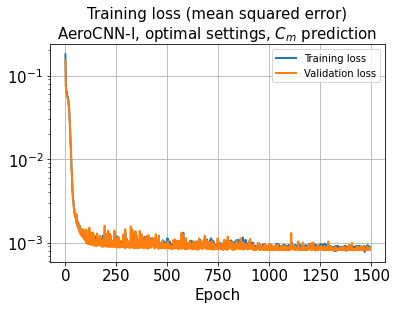

In [33]:
hist = history.history
plt.plot(hist['loss'], lw=2, label='Training loss')
plt.plot(hist['val_loss'], lw=2, label='Validation loss')
plt.title('Training loss (mean squared error)\nAeroCNN-I, optimal settings, $C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
#plt.ylim([5e-5, 1e-1])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "TrainingLoss_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

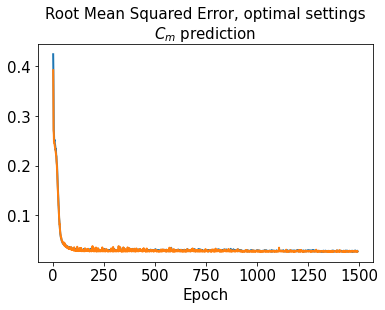

In [34]:
plt.plot(hist['rmse'], lw=2)
plt.plot(hist['val_rmse'], lw=2)
plt.title('Root Mean Squared Error, optimal settings\n$C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

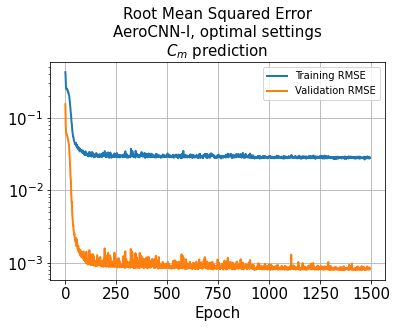

In [35]:
plt.plot(hist['rmse'], lw=2, label='Training RMSE')
plt.plot(hist['val_loss'], lw=2, label='Validation RMSE')
plt.title('Root Mean Squared Error\nAeroCNN-I, optimal settings\n$C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "RMSE_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [36]:
train_results = model.evaluate([x_time_train, x_coord_train], y_train)

66/66 [==============================] - 0s 4ms/step - loss: 8.4740e-04 - rmse: 0.0280


In [37]:
val_results = model.evaluate([x_time_val, x_coord_val], y_val)

19/19 [==============================] - 0s 5ms/step - loss: 8.0524e-04 - rmse: 0.0272


In [38]:
test_results = model.evaluate([x_time_test, x_coord_test], y_test)

10/10 [==============================] - 0s 8ms/step - loss: 9.3664e-04 - rmse: 0.0295


In [39]:
decoded_train_ = model.predict([x_time_train, x_coord_train])
decoded_val_ = model.predict([x_time_val, x_coord_val])
decoded_test_ = model.predict([x_time_test, x_coord_test])

10/10 [==============================] - 0s 2ms/step


In [40]:
def define_index(y_total, y_partial):
    return np.unique(np.where(np.isin(y_total, y_partial)))

In [41]:
def error_absolute(y_pred, y_true):
    return np.abs(y_pred - y_true)

In [42]:
# Denormalize 
def denormalize(y):
    return y*(np.max(cm)-np.min(cm))+np.min(cm)

In [43]:
def l2_error(y_pred, y_real):
    return np.sqrt(np.sum((y_pred - y_real)**2) / np.sum(y_real**2))

def mape(y_pred, y_real):
    return 100/len(y_real) * np.sum(np.abs((y_real-y_pred)/y_real))

def smape(y_pred, y_real):
    return 100*np.sum(np.abs(y_pred-y_real))/np.sum(y_real + y_pred)

In [44]:
index_train = define_index(y, y_train)
index_val = define_index(y, y_val)
index_test = define_index(y, y_test)

In [45]:
l2_error_train = l2_error(decoded_train_, y_train)
mape_train = smape(decoded_train_, y_train)
print(l2_error_train)
print(mape_train)

0.06394363573063219
2.41680353519537


In [46]:
l2_error_val = l2_error(decoded_val_, y_val)
mape_val= smape(decoded_val_, y_val)
print(l2_error_val)
print(mape_val)

0.06443474433770684
2.4191978516193546


In [47]:
l2_error_test = l2_error(decoded_test_, y_test)
mape_test= smape(decoded_test_, y_test)
print(l2_error_test)
print(mape_test)

0.06578930349323461
2.493797832166526


In [48]:
y_train = denormalize(y_train)
y_val = denormalize(y_val)
y_test = denormalize(y_test)

In [49]:
decoded_train = denormalize(decoded_train_)
decoded_val = denormalize(decoded_val_)
decoded_test = denormalize(decoded_test_)

In [50]:
model_directory = "D:\\TrainedModels\\20230103"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)
os.chdir(model_directory)
model_name = "20230103unsteady_AeroCNN1_3Case(131415)(l2)(flapOnly0.002)_val_"+str(val_rate)+"_test"+str(test_rate)+ "_" + str(n_kernels)+"kernels_" + str(n_layers) +"layers_"+str(n_units)+"units_CmPrediction.h5"
model.save(model_name, overwrite=True, include_optimizer=True, save_format='h5')

In [51]:
error_train_abs = error_absolute(decoded_train, y_train)
error_val_abs = error_absolute(decoded_val, y_val)
error_test_abs = error_absolute(decoded_test, y_test)

In [52]:
os.chdir(storage_dir)

In [53]:
l2_error_train_list = []
for i in range(0, len(x_time_train)):
    l2_error_train_data = l2_error(decoded_train[i], y_train[i])
    l2_error_train_list.append(l2_error_train_data)

In [54]:
l2_error_val_list = []
for i in range(0, len(x_time_val)):
    l2_error_val_data = l2_error(decoded_val[i], y_val[i])
    l2_error_val_list.append(l2_error_val_data)

In [55]:
l2_error_test_list = []
for i in range(0, len(x_time_test)):
    l2_error_test_data = l2_error(decoded_test[i], y_test[i])
    l2_error_test_list.append(l2_error_test_data)

In [56]:
mape_train_list = []
for i in range(0, len(x_time_train)):
    mape_train_data = smape(decoded_train[i], y_train[i])
    mape_train_list.append(mape_train_data)

In [57]:
mape_val_list = []
for i in range(0, len(x_time_val)):
    mape_val_data = smape(decoded_val[i], y_val[i])
    mape_val_list.append(mape_val_data)

In [58]:
mape_test_list = []
for i in range(0, len(x_time_test)):
    mape_test_data = smape(decoded_test[i], y_test[i])
    mape_test_list.append(mape_test_data)

In [59]:
def distribution_plot(y_pred, y_real, dataset="train"):
    dictionary_name = {"train":"training", "val":"validation", "test":"test"}
    dictionary_data = {"train":l2_error_train_list, "val":l2_error_val_list, "test":l2_error_test_list}
    dictionary_error = {"train":l2_error_train, "val":l2_error_val, "test":l2_error_test}
    plot_title = '$L_2$ error norm distribution - MLP, unsteady, '+ dictionary_name.get(dataset) +'.\nValidation rate {0}, test rate {1}, {2} layers, {3} units ($C_m$)'.format(
        val_rate, test_rate, n_layers, n_units)
    plt.plot(np.linspace(1,y_real.shape[0],y_real.shape[0]),
             dictionary_error.get(dataset)*np.ones(y_real.shape[0],), 'k', lw=2.5)
    plt.scatter(np.linspace(1, y_real.shape[0], y_real.shape[0]), dictionary_data.get(dataset), c='b')
    plt.xlabel('Index', fontsize=15)
    plt.ylabel('$L_2$ error norm', fontsize=15)
    plt.yscale('log')
    plt.title(plot_title, fontsize=15)
    plt.grid()

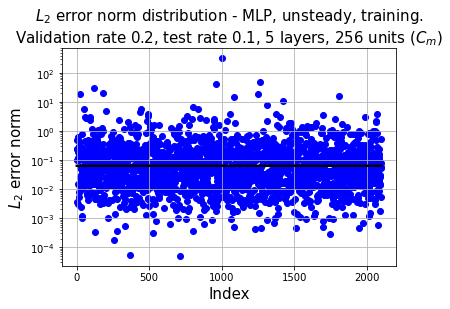

In [60]:
distribution_plot(decoded_train, y_train, dataset="train")
saveName = "trainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

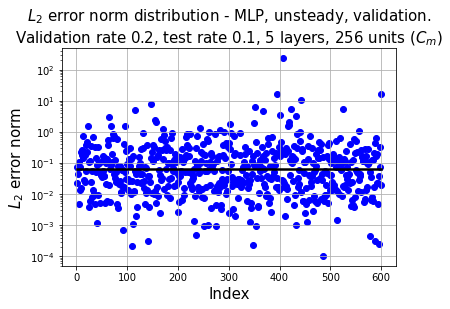

In [61]:
distribution_plot(decoded_val, y_val, dataset="val")
saveName = "validationErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

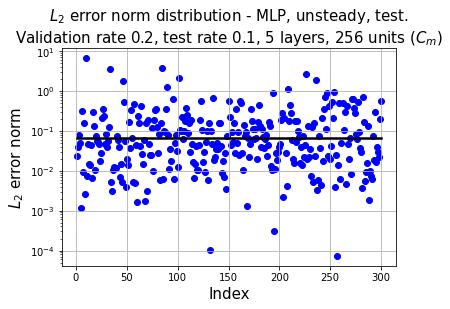

In [62]:
distribution_plot(decoded_test, y_test, dataset="test")
saveName = "testErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [63]:
predicted = model.predict([x_time, x_coord])

94/94 [==============================] - 0s 2ms/step


In [64]:
tTrain = x_time[index_train] + 10
tVal = x_time[index_val] + 10
tTest = x_time[index_test] + 10

In [65]:
max(predicted)

array([0.9585963], dtype=float32)

In [66]:
print(l2_error(predicted, y))

0.06423387003063745


In [67]:
cm[2000]

array([0.00682824])

In [68]:
cm[1000]

array([0.0014248])

In [69]:
# Each set of data in sorted order
iTrain=[]
iVal=[]
iTest=[]
for i, index in enumerate(index_train):
    iTrain.append(y[index])
for k , index in enumerate(index_val):
    iVal.append(y[index])
for j, index in enumerate(index_test):
    iTest.append(y[index])

In [70]:
iTrain = np.array(iTrain)
iVal = np.array(iVal)
iTest = np.array(iTest)

In [71]:
t

array([[0.   ],
       [0.001],
       [0.002],
       ...,
       [0.997],
       [0.998],
       [0.999]])

In [72]:
def Cm_trainTestSplit_Plot(i, Cm, cm, tTrain, tVal, tTest, iTrain, iVal, iTest):
    
    title_0_Cm = 'Gurney flap not attached (NACA0018)\n$C_m$ prediction, $L_2$ error=%.4f' % l2_error_Cm    
    title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, $L_2$ error=%.4f'%(l2_error_Cm)
    
    if i==0:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    else:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    
    # Cm graph plot
    plt.plot(t[:1000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:1000], denormalize(cm), 'k--', label='Predicted value')
    plt.scatter(tTrain, denormalize(iTrain), color='b', label='Training set')
    plt.scatter(tVal, denormalize(iVal), color='g', label='Validation set')
    plt.scatter(tTest,denormalize(iTest), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper left')
    plt.ylim([-0.05, 0.22])
    plt.grid()
    plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

In [73]:
len(predicted[index_train])

2100

In [74]:
len(predicted[index_val])

601

In [75]:
len(predicted[index_test])

301

In [76]:
x_time += 10

L2 error of Cm: 0.0821


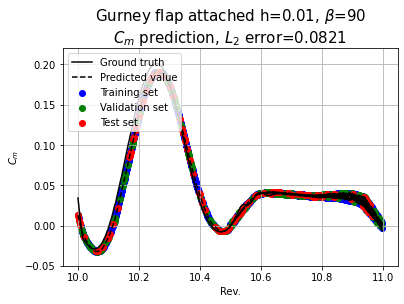

L2 error of Cm: 0.0120


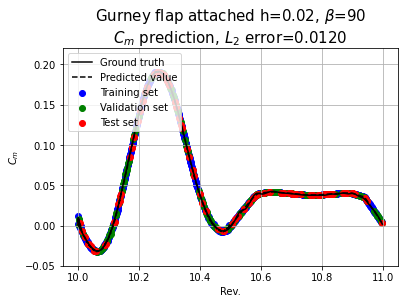

L2 error of Cm: 0.0736


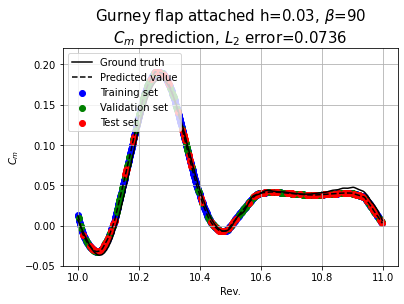

In [77]:
h = [0.01, 0.02, 0.03]
beta = [90, 90, 90]
for i in range(0,3):
    #Index from each dataset in sorted order
    iTrain_ = []
    iVal_ = []
    iTest_ = []
    
    # Index from input data (alpha, in this case)
    t_train = []
    t_val = []
    t_test = []
    
    predictedValue = predicted[t_len*i:t_len*(i+1),:]
    y_corres = y[t_len*i:t_len*(i+1),:]
    
    l2_error_Cm = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    print('L2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    
    cm_ = predictedValue#denormalize(predictedValue)
    Cm = y_corres#denormalize(y_corres)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        iTrain_.append(predicted[index])
    for jj, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        iVal_.append(predicted[index])    
    for kk, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & (index_test>=i*t_len))]):
        iTest_.append(predicted[index])
        
#     iTrain = denormalize(np.array(iTrain))
#     iTest = denormalize(np.array(iTest))
#     iVal = denormalize(np.array(iVal))
    iTrain_ = np.array(iTrain_)
    iVal_ = np.array(iVal_)
    iTest_ = np.array(iTest_)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        t_train.append(t[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        t_val.append(t[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & ((index_test>=i*t_len)))]):
        t_test.append(t[index])
        
    tTrain = np.array(t_train)
    tVal = np.array(t_val)
    tTest = np.array(t_test)
        
    Cm_trainTestSplit_Plot(i, Cm, cm_, tTrain, tVal, tTest, iTrain_, iVal_, iTest_)

In [78]:
def Cm_trainTestSplit_Plot2(i, Cm, cm, tTrain, tVal, tTest, iTrain, iVal, iTest):
    
    title_0_Cm = 'Gurney flap not attached (NACA0018)\n$C_m$ prediction, $L_2$ error=%.4f' % l2_error_Cm    
    title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, $L_2$ error=%.4f'%(l2_error_Cm)
    
    if i==0:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    else:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    
    # Cm graph plot
    plt.plot(t[:1000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:1000], denormalize(cm), 'r--', label='Predicted value')
#     plt.scatter(tTrain, denormalize(iTrain), color='b', label='Training set')
#     plt.scatter(tVal, denormalize(iVal), color='g', label='Validation set')
#     plt.scatter(tTest,denormalize(iTest), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper right')
    plt.xlim([10.17, 10.23])
    plt.ylim([0.11, 0.15])
    plt.grid()
    plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

L2 error of Cm: 0.0821


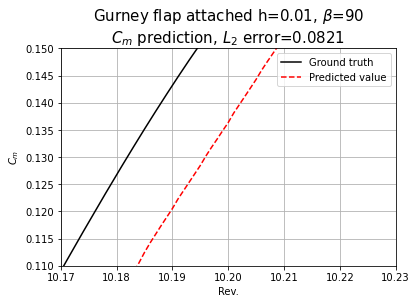

L2 error of Cm: 0.0120


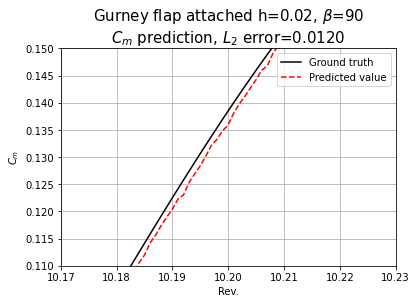

L2 error of Cm: 0.0736


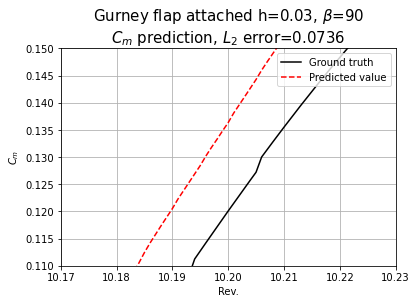

In [79]:
for i in range(0,3):
    #Index from each dataset
    iTrain_ = []
    iVal_ = []
    iTest_ = []
    
    # Index from input data (alpha, in this case)
    t_train = []
    t_val = []
    t_test = []
    
    predictedValue = predicted[t_len*i:t_len*(i+1),:]
    y_corres = y[t_len*i:t_len*(i+1),:]
    
    l2_error_Cm = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    print('L2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    
    cm_ = predictedValue#denormalize(predictedValue)
    Cm = y_corres#denormalize(y_corres)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        iTrain_.append(predicted[index])
    for jj, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        iVal_.append(predicted[index])    
    for kk, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & (index_test>=i*t_len))]):
        iTest_.append(predicted[index])
        
#     iTrain = denormalize(np.array(iTrain))
#     iTest = denormalize(np.array(iTest))
#     iVal = denormalize(np.array(iVal))
    iTrain_ = np.array(iTrain_)
    iVal_ = np.array(iVal_)
    iTest_ = np.array(iTest_)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        t_train.append(t[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        t_val.append(t[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & ((index_test>=i*t_len)))]):
        t_test.append(t[index])
        
    tTrain = np.array(t_train)
    tVal = np.array(t_val)
    tTest = np.array(t_test)
        
    Cm_trainTestSplit_Plot2(i, Cm, cm_, tTrain, tVal, tTest, iTrain_, iVal_, iTest_)

L2 error of Cm: 0.0821


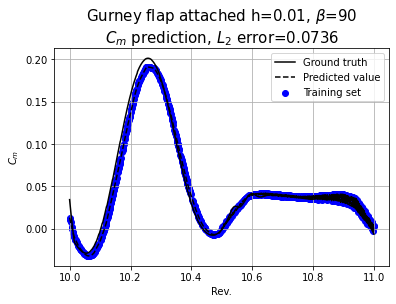

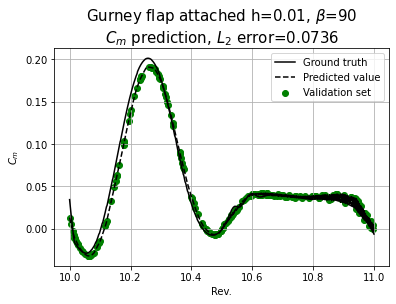

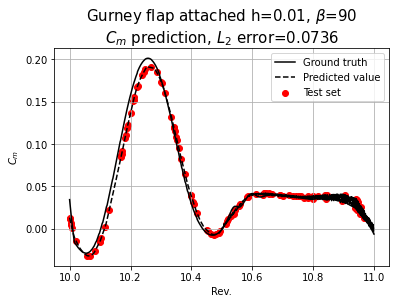

L2 error of Cm: 0.0120


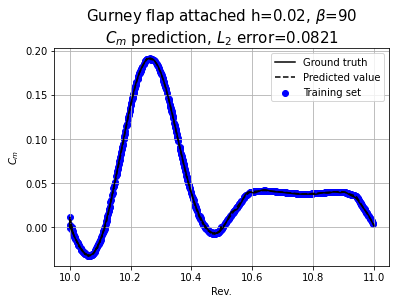

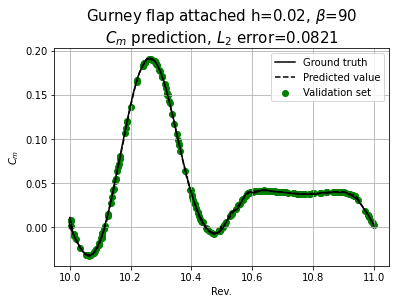

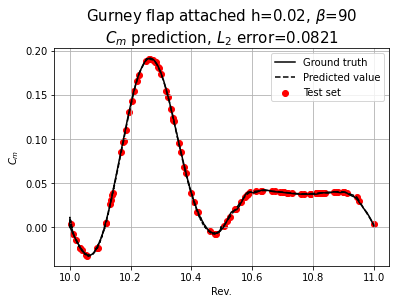

L2 error of Cm: 0.0736


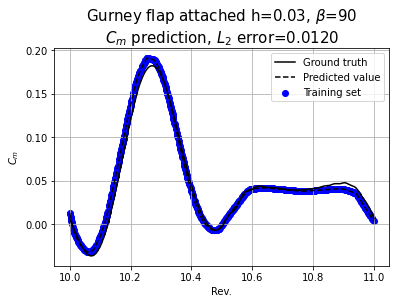

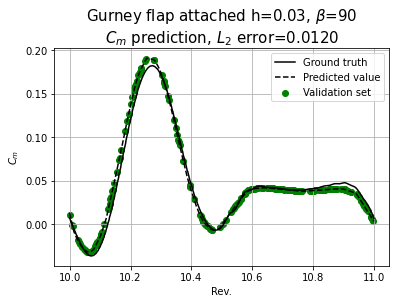

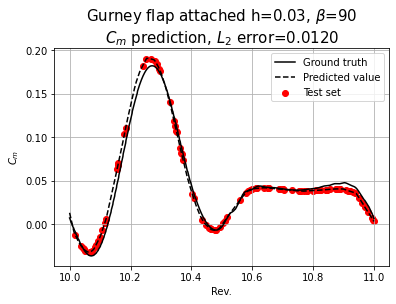

In [80]:
for i in range(0,3):
    #Index from each dataset
    iTrain_ = []
    iVal_ = []
    iTest_ = []
    
    # Index from input data (alpha, in this case)
    t_train = []
    t_val = []
    t_test = []
    title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, $L_2$ error=%.4f'%(l2_error_Cm)
    
    title_Cm = title_n_Cm
    savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"

    predictedValue = predicted[t_len*i:t_len*(i+1),:]
    y_corres = y[t_len*i:t_len*(i+1),:]
    
    l2_error_Cm = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    print('L2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    
    cm_ = predictedValue#denormalize(predictedValue)
    Cm = y_corres#denormalize(y_corres)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        iTrain_.append(predicted[index])
    for jj, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        iVal_.append(predicted[index])    
    for kk, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & (index_test>=i*t_len))]):
        iTest_.append(predicted[index])
        
#     iTrain = denormalize(np.array(iTrain))
#     iTest = denormalize(np.array(iTest))
#     iVal = denormalize(np.array(iVal))
    iTrain_ = np.array(iTrain_)
    iVal_ = np.array(iVal_)
    iTest_ = np.array(iTest_)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        t_train.append(t[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        t_val.append(t[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & ((index_test>=i*t_len)))]):
        t_test.append(t[index])
        
    tTrain = np.array(t_train)
    tVal = np.array(t_val)
    tTest = np.array(t_test)

    # Cm graph plot
    ## Training dataset
    plt.plot(t[:1000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:1000], denormalize(cm_), 'k--', label='Predicted value')
    #plt.scatter(tTrain, iTrain, color='b', label='Training set')
    #plt.scatter(tVal, iVal, color='g', label='Validation set')
    plt.scatter(tTrain, denormalize(iTrain_), color='b', label='Training set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper right')
    #plt.ylim([0, 0.0042])
    plt.grid()
    #plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()
    
    ## Validation dataset
    plt.plot(t[:1000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:1000], denormalize(cm_), 'k--', label='Predicted value')
    plt.scatter(tVal, denormalize(iVal_), color='g', label='Validation set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper right')
    #plt.ylim([0, 0.0042])
    plt.grid()
    #plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()
    
    ## Test dataset
    plt.plot(t[:1000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:1000], denormalize(cm_), 'k--', label='Predicted value')
    plt.scatter(tTest, denormalize(iTest_), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper right')
    #plt.ylim([0, 0.0042])
    plt.grid()
    #plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()